In [334]:
"""
HERFD Simulation
by Yanna Chen, yannachen@anl.gov

Version note: 
From HERFD v1, beam focus from SBCA is added. 
v1.1 has multiple reflected lines to indicate  the Johann error.
v1.1.1 set np.radians(beta_deg) = 2*alpha 
v1.1.1s for symmetric design
v1.1 for symmetric design
v2 Add 3D and merge symmetric and asymmetric, add auto find hkl
v2.1 Add hkl0 (surface lattice plane) and hkl_phi0 (surface cut edge) of SBCA as parameters
v3.0 Set beta = 0 for new HERFD design, add emission energy velocity calculation 
"""

'\nHERFD Simulation\nby Yanna Chen, yannachen@anl.gov\n\nVersion note: \nFrom HERFD v1, beam focus from SBCA is added. \nv1.1 has multiple reflected lines to indicate  the Johann error.\nv1.1.1 set np.radians(beta_deg) = 2*alpha \nv1.1.1s for symmetric design\nv1.1 for symmetric design\nv2 Add 3D and merge symmetric and asymmetric, add auto find hkl\nv2.1 Add hkl0 (surface lattice plane) and hkl_phi0 (surface cut edge) of SBCA as parameters\nv3.0 Set beta = 0 for new HERFD design, add emission energy velocity calculation \n'

In [335]:
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import itertools

plt.rcParams["font.family"] = "Arial"

%matplotlib widget

# Constants
(Please use units: mm, nm, eV)

## Physical constant

In [336]:
# Plank constant times the light speed
hc = 1239.84193  # The following energy should be in the unit of eV

## Setup constant 

In [337]:
# define sample position in Cartesian coordinate 
sample_x = 0
sample_y = 0 # mm = 18 inch = 457.2 mm
sample_z = 0

# Roland Circle diameter
D = 501.3 #495 #Jerry 211 #497.5 #SPC 211 #502.5 # 911 unit: mm
# Crystal diameter
crysD = 100 # unit: mm
# Angles between each SBCA and X-ray beam
angles2beam = np.arange(60,121,20)

# Si lattice constant
lattice_cons = 0.543095  # unit: nm
#hkl0 = [2,1,1] # lattice plane for SBCA
# hkl_phi0 = [1,1,1] # set [1,1,1] as phi=0 [1,-1,0] [-1,1,0]

# Crystal stage
vert0 = 45

## Note:

In [338]:
# Crystal arc angle
np.degrees(np.arcsin(crysD/2/D))*2

11.448475096564087

# Functions

## hkl list

In [339]:
# To calculate energy, e.g. [7,3,1] and [7,1,3] are the same, only [7,3,1] is created.
def generate_hkl(n):
    hkl_list = []
    for h in range(n+1):
        for k in range(h+1):
                for l in range(h+1):
                    # Check if h, k, l are all odd
                    if (h % 2 != 0 and k % 2 != 0 and l % 2 != 0):
                        hkl = sorted([h, k, l], reverse=True)
                        if hkl not in hkl_list:
                            hkl_list.append(hkl)
                    # Check if h, k, l are all even and their sum is a multiple of 4
                    elif (h % 2 == 0 and k % 2 == 0 and l % 2 == 0):
                        if (h + k + l) % 4 == 0 and (h, k, l) != (0, 0, 0):
                            hkl = sorted([h, k, l], reverse=True)
                            if hkl not in hkl_list:
                                hkl_list.append(hkl)
    return hkl_list
# To create phi-alpha 2D plot, e.g. [7,3,1] and [7,1,3] are both used.
def generate_hkl_phi(n):
    hkl_list = []
    for h in range(n+1):
        for k in range(n+1):
                for l in range(n+1):
                    if (h % 2 != 0 and k % 2 != 0 and l % 2 != 0):
                        hkl = [h, k, l]
                        if hkl not in hkl_list:
                            hkl_list.append(hkl)
                    elif (h % 2 == 0 and k % 2 == 0 and l % 2 == 0):
                        if (h + k + l) % 4 == 0 and (h, k, l) != (0, 0, 0):
                            hkl = [h, k, l]
                            if hkl not in hkl_list:
                                hkl_list.append(hkl)
    return hkl_list

def order_hkl_by_sum_of_squares(hkl_list):
    return sorted(hkl_list, key=lambda x: 1/(x[0]**2 + x[1]**2 + x[2]**2))

# print(ordered_hkl_list_phi)


## Calculate Bragg angle

In [340]:
def theta_bragg(energy_val, hkl=[4,4,4]):
    """
    theta_bragg unit: deg
    """
    d_spacing = lattice_cons / np.sqrt(hkl[0] ** 2 + hkl[1] ** 2 + hkl[2] ** 2)
    theta_bragg_val = np.arcsin(hc / (energy_val * 2 * d_spacing))
    theta_bragg_val = np.degrees(theta_bragg_val)
    return theta_bragg_val

## Calculate energy 

In [341]:
def energy(theta_bragg, hkl=[4,4,4]):
    """
    theta_bragg unit: deg
    """
    d_spacing = lattice_cons / np.sqrt(hkl[0] ** 2 + hkl[1] ** 2 + hkl[2] ** 2)
    energy = hc / (2 * d_spacing * np.sin(np.radians(theta_bragg)))
    return energy

## Calculate asymmetry angle

In [342]:
    
def cal_alpha(hkl1=[2,1,1], hkl2=[4,4,4]):
    """
    alpha unit: deg
    """
    cos_alpha = (hkl1[0]*hkl2[0]+hkl1[1]*hkl2[1]+hkl1[2]*hkl2[2])/np.sqrt(hkl1[0]**2+hkl1[1]**2+hkl1[2]**2)/np.sqrt(hkl2[0]**2+hkl2[1]**2+hkl2[2]**2)
    if cos_alpha>1:
        cos_alpha=1
    alpha = np.arccos(cos_alpha)
    alpha = np.degrees(alpha)
    return alpha

## Reflected line based on lattice plane normal direction 

In [343]:
def angle_between_lines(slope0, slope1):
    """
    angle unit: deg
    """
    return np.degrees(np.arctan(np.abs((slope1 - slope0) / (1 + slope0 * slope1))))

def reflected_line(slope_angle, x0, y0, x1, y1, x2,figure=True):
    """
    slop angle: for SBCA normal line ; unit deg
    x0,y0: cross point
    x1,y1: incident beam start point
    x2: reflected beam end point
    """
    # Slope of the normal line
    slope0 = np.tan(np.radians(slope_angle))
    # Slope of the incident line
    slope1 = (y1 - y0) / (x1 - x0)
    # Calculate angle between the normal line and the incident line
    theta_deg = angle_between_lines(slope0, slope1)
    if theta_deg >90:
        theta_deg = 180-theta_deg
    # Calculate slope angle for the reflected line
    theta1_deg = slope_angle-theta_deg
    # Calculate slope of the reflected line
    slope2 = np.tan(np.radians(theta1_deg))
    y2 = slope2 * (x2 - x0) + y0
    if figure:
        # Generate x values for the third line
        x_values = np.linspace(x2, x0, 100)
        # Calculate y values for the normal line to the lattice plane
        y0_values = slope0 * (x_values - x0) + y0
        # Calculate y values for the incident line
        y1_values = slope1 * (x_values - x0) + y0
        # Calculate y values for the reflected line
        y2_values = slope2 * (x_values - x0) + y0
        # Plotting
        #plt.plot(x_values, y0_values,  'r--', linewidth=1) #label='Normal Line',
        #plt.plot(x_values, y1_values,  'b-', linewidth=1) #label='Incident Line',
        plt.plot(x_values, y2_values, 'y-', linewidth=1) #label='Reflected Line',
        # Plotting points A and B
        #plt.scatter(x0, y0, color='black', label='Point A')
        #plt.scatter(x1, y1, color='black', label='Point B')
    return y2

In [344]:
def reflected_line_3D(slope_angle, x0, y0, z0, x1, y1, z1, x2, z2, figure=True):
    """
    slop angle: for SBCA normal line ; unit deg
    x0,y0: cross point
    x1,y1: incident beam start point
    x2: reflected beam end point
    """
    # Slope of the normal line
    slope0 = np.tan(np.radians(slope_angle))
    # Slope of the incident line
    slope1 = (y1 - y0) / (np.sqrt(x1**2+z1**2) - np.sqrt(x0**2+z0**2))
    # Calculate angle between the normal line and the incident line
    theta_deg = angle_between_lines(slope0, slope1)
    if theta_deg > 90:
        theta_deg = 180-theta_deg
    # Calculate slope angle for the reflected line
    theta1_deg = slope_angle-theta_deg
    # Calculate slope of the reflected line
    slope2 = np.tan(np.radians(theta1_deg))
    y2 = slope2 * (sp.sqrt(x2**2 + z2**2) - sp.sqrt(x0**2 + z0**2)) + y0
    y2 = y2.evalf()  # Convert the result to a numerical value
    if figure:
        # Generate x values for the third line
        x_values = np.linspace(x2, x0, 100)
        z_values = np.linspace(z2, z0, 100)
        # Calculate y values for the normal line to the lattice plane
        y0_values = slope0 * (np.sqrt(x_values**2+z_values**2) - np.sqrt(x0**2+z0**2)) + y0
        # Calculate y values for the incident line
        y1_values = slope1 * (np.sqrt(x_values**2+z_values**2) - np.sqrt(x0**2+z0**2)) + y0
        # Calculate y values for the reflected line
        y2_values = slope2 * (np.sqrt(x_values**2+z_values**2)- np.sqrt(x0**2+z0**2)) + y0
        # Plotting
        ax = plt.subplot(111, projection='3d')
        #ax.plot(x_values, y0_values, z_values, 'r--', linewidth=1, label='Normal Line',) #
        #ax.plot(x_values, y1_values, z_values, 'b-', linewidth=1, label='Incident Line',) #
        ax.plot(x_values, y2_values, z_values, 'y-', linewidth=0.2,) # label='Reflected Line',
        # Plotting points A and B
        #ax.scatter(x0, y0, z0, color='blue', label='Point A')
        #ax.scatter(x1, y1, z1, color='red', label='Point B')
        #ax.view_init(elev=120, azim=240, roll=-30)
        #ax.set_xlabel('x')
        #ax.set_ylabel('y')
        #ax.set_zlabel('z')
        #ax.legend()
    return y2

## Plot a circle 

In [345]:
def plot_circle(x0, y0, D):
    """
    (x0,y0): circle center
    D: Roland circle diameter
    """
    # Create a range of angles from 0 to 2*pi (360 degrees)
    angles_rad = np.linspace(0, 2*np.pi, 100)
    # Calculate x and y coordinates of the circle
    x = x0 + (D / 2) * np.cos(angles_rad)
    y = y0 + (D / 2) * np.sin(angles_rad)
    # Plot the circle
    plt.plot(x, y, 'c-', linewidth=0.5)

In [346]:
def plot_circle_3D(x0, y0, z0, D, angle2beam=45):
    """
    (x0,y0): circle center
    D: Roland circle diameter
    """
    # Create a range of angles from 0 to 2*pi (360 degrees)
    angles_rad = np.linspace(0, 2*np.pi, 100)
    # Calculate x, y, and z coordinates of the circle
    z = z0 - (D / 2) * np.cos(angles_rad)*np.cos(np.radians(angle2beam)) 
    x = x0 + (D / 2) * np.cos(angles_rad)*np.sin(np.radians(angle2beam)) 
    y = y0 + (D / 2) * np.sin(angles_rad)
    # Plot the circle in 3D
    ax = plt.subplot(111, projection='3d')
    ax.plot(x, y, z, 'c-', linewidth=0.5)

## Plot SBCA arc

In [347]:
def plot_sbca_arc(x0,y0,beta_deg):
    """
    (x0,y0): SBCA circle center
    beta: deg
    """
    arc_angle_rad = np.arcsin(crysD/2/D)
    # angle range for the SBCA arc
    arc_angle_range = np.linspace(-arc_angle_rad, arc_angle_rad, 10)     
    x_arc = x0+D*np.cos(arc_angle_range+np.radians(beta_deg))
    y_arc = y0+D*np.sin(arc_angle_range+np.radians(beta_deg))
    plt.plot(x_arc, y_arc, 'b-',linewidth=1)

In [348]:
def plot_sbca_arc_3D(x0,y0,z0,beta_deg,angle2beam=45):
    """
    (x0,y0,z0): SBCA circle center
    beta: deg
    """
    arc_angle_rad = np.arcsin(crysD/2/D)
    # angle range for the SBCA arc
    arc_angle_range = np.linspace(-arc_angle_rad, arc_angle_rad, 10)
    z_arc = z0-D*np.cos(arc_angle_range+np.radians(beta_deg))*np.cos(np.radians(angle2beam))
    x_arc = x0+D*np.cos(arc_angle_range+np.radians(beta_deg))*np.sin(np.radians(angle2beam))
    y_arc = y0+D*np.sin(arc_angle_range+np.radians(beta_deg))
    plt.plot(x_arc, y_arc, z_arc, 'b-',linewidth=1)

In [349]:
def plot_sbca(x0,y0,z0,x1,y1,z1,beta_deg,angle2beam=45):
    """
    (x0,y0,z0): SBCA circle center
    (x1,y1,z1): SBCA crystal center
    beta: deg
    """
    # Define the spherical coordinates
    arc_angle_rad = np.arcsin(crysD/2/D)
    theta = np.linspace(np.radians(beta_deg)-1.5*arc_angle_rad, np.radians(beta_deg)+1.5*arc_angle_rad, 1000) 
    phi = np.linspace(np.radians(angle2beam)-1.5*arc_angle_rad, np.radians(angle2beam)+1.5*arc_angle_rad, 1000) 
    theta, phi = np.meshgrid(theta, phi)
    # Convert spherical coordinates to Cartesian coordinates and shift by the center
    z = z0 - D * np.cos(theta) * np.cos(phi) 
    x = x0 + D * np.cos(theta) * np.sin(phi) 
    y = y0 + D * np.sin(theta) 
    r_crys = 2*D*np.sin(arc_angle_rad/2)
    # Calculate Euclidean distance from each point to the center of the ROI
    distance = np.sqrt((x - x1)**2 + (y - y1)**2 + (z - z1)**2)
    # Create a mask for the circular ROI based on Euclidean distance
    mask = distance <= r_crys
    ax = plt.subplot(111, projection='3d')
    # Define face colors
    facecolor = np.array([0, 0, 1, 0.5])  # Blue with alpha=0.5
    facecolors = np.ones((x.shape[0], x.shape[1], 4)) * facecolor
    # Set fully transparent where mask is False
    facecolors[~mask] = [0, 0, 0, 0]
    ax.plot_surface(x, y, z, facecolors=facecolors, edgecolor='none')

## hkl energy range dataframe

In [350]:
def hkl_dataframe(hkl0=[2,1,1], hkl_list = [[111],[311]], thetaB_range = np.arange(60,85,1), figure=True, pltEmin=3000, pltEmax=18000):
    hkl_data = []
    # Create subplots for each hkl plane
    if figure:
        fig,axs = plt.subplots(len(hkl_list), 1, figsize=(8, 0.3* len(hkl_list)), sharex=True, sharey=True, gridspec_kw={'hspace': 0})
        # plt.title(str(hkl0), fontsize=14, fontname="Arial")
        fig.text(0.5, 0.9, f"Crystal:{hkl0}", ha='center', fontsize=14, fontname="Arial")
    # Plot each hkl plane on its own subplot
    for i, hkl in enumerate(hkl_list):
        alpha_val = cal_alpha(hkl0, hkl)
        energy_range = []
        for ang in thetaB_range:
            en_val = energy(ang, hkl)
            energy_range.append(en_val)
            # Get Emin and Emax for the current hkl plane
        Emin = min(energy_range)
        Emax = max(energy_range)
        # Append hkl and corresponding Emin, Emax to the list
        hkl_data.append({'hkl': hkl, 'alpha': alpha_val, 'Emin': Emin, 'Emax': Emax})
        if figure:
            axs[i].plot(energy_range, thetaB_range, label=f'{hkl}')
            # if alpha_val < 12 and alpha_val > 4:
            #     axs[i].text(1.1, 0.00, f'{hkl}, {alpha_val}', transform=axs[i].transAxes, fontsize=10, ha='right', va='bottom')
            axs[i].text(1.1, 0.00, f'{hkl}, {alpha_val:.2f}', transform=axs[i].transAxes, fontsize=10, ha='right', va='bottom')
            #axs[i].set_xticks(np.arange(0, 100000, 1000))
            axs[i].set_yticks(np.arange(60, 90, 15))
            axs[i].set_xlim(pltEmin,pltEmax)
            axs[i].set_ylim(60,90)
    # Create a DataFrame from the list
    hkl_df = pd.DataFrame(hkl_data)
    return hkl_df

In [351]:
def hkl_dataframe_thetaM(hkl0=[2,1,1], hkl_list = [[111],[311]], theta_M_range = np.arange(88,96,1), figure=True, pltEmin=3000, pltEmax=18000):
    hkl_data = []
    # Create subplots for each hkl plane
    if figure:
        fig, axs = plt.subplots(len(hkl_list), 1, figsize=(8, 0.2* len(hkl_list)), sharex=True, sharey=True, gridspec_kw={'hspace': 0})
        # plt.title(str(hkl0), fontsize=14, fontname="Arial")
        fig.text(0.5, 0.9, f"Crystal:{hkl0}", ha='center', fontsize=14, fontname="Arial")
    # Plot each hkl plane on its own subplot
    for i, hkl in enumerate(hkl_list):
        alpha_val = cal_alpha(hkl0, hkl)
        energy_range = []
        for ang in theta_M_range:
            en_val = energy(ang-alpha_val, hkl)
            energy_range.append(en_val)
            # Get Emin and Emax for the current hkl plane
        Emin = min(energy_range)
        Emax = max(energy_range)
        # Append hkl and corresponding Emin, Emax to the list
        hkl_data.append({'hkl': hkl, 'alpha': alpha_val, 'Emin': Emin, 'Emax': Emax})
        if figure:
            axs[i].plot(energy_range, theta_M_range, label=f'{hkl}')
            # if alpha_val < 12 and alpha_val > 4:
            #     axs[i].text(1.1, 0.00, f'{hkl}, {alpha_val}', transform=axs[i].transAxes, fontsize=10, ha='right', va='bottom')
            axs[i].text(1.1, 0.00, f'{hkl}, {alpha_val:.2f}', transform=axs[i].transAxes, fontsize=10, ha='right', va='bottom')
            #axs[i].set_xticks(np.arange(0, 100000, 1000))
            # axs[i].set_yticks(np.arange(85, 100, 15))
            axs[i].set_xlim(pltEmin,pltEmax)
            # axs[i].set_ylim(85,100)
    # Create a DataFrame from the list
    hkl_df = pd.DataFrame(hkl_data)
    return hkl_df

## Find hkl for an energy (delEn=delEp=0) or energy range(energy+delEn, energy+delEp)

In [352]:
def find_hkl(hkl0=[2,1,1], hkl_list = [[1,1,1],[5,1,1]], thetaB_range = np.arange(60,85,1), energy_val=9000, delEn=-45, delEp=25, delAlpha=30, delThetaB=10):
    """
    Asumme alpha0=15 deg, theta0=90 deg
    hkl_df is a daframe of three columns: hkl, Emin, Emax
    delEn: energy range at low end, -45 eV 
    delEp: energy range at high end, 25 eV 
    delAlpha: define alpha range as 15-delAlpha < alpha < 15+delAlpha
    delThetaB: define ThetaB range as theta_B > 90-delThetaB
    """
    hkl_df=hkl_dataframe(hkl0=hkl0, hkl_list = hkl_list, thetaB_range = thetaB_range, figure=False)
    energy1 = energy_val+delEn
    energy2 = energy_val+delEp
    # Filter the DataFrame
    filtered_df = hkl_df[(hkl_df['Emin'] < energy1) & (hkl_df['Emax'] > energy2)]
    # Initialize an empty list to store the angles
    angles = []
    # Iterate over each row in the filtered DataFrame
    for hkl_val in filtered_df['hkl']:
        theta_B_deg = theta_bragg(energy1, hkl=hkl_val)
        alpha_deg = cal_alpha(hkl1=hkl0, hkl2=hkl_val)
        theta_M_deg = theta_B_deg + alpha_deg
        hkl_sq = hkl_val[0]**2 + hkl_val[1]**2 + hkl_val[2]**2
        # Append hkl and corresponding angles to the list
        #angles.append({'hkl': hkl_val, )
        angles.append({'hkl': hkl_val, 'hkl_sq': hkl_sq, 'theta_B': theta_B_deg, 'alpha': alpha_deg, 'theta_M': theta_M_deg})
    # Create a DataFrame from the list of angles
    angles_df = pd.DataFrame(angles)
    # Find the row with the angle closest to 90 degrees
    #angles_df['angle_diff'] = abs(angles_df['theta_M'] - 90)
    angles_df['angle_diff_thetaB'] = abs(angles_df['theta_B'] - 90) # theta_B angle deviation from 90 deg
    angles_df['angle_diff_alpha'] = abs(angles_df['alpha'] - 15) # alpha angle deviation from 15 deg
    
    # the case where alpha0-delAlpha <= alpha <= alpha0+delAlpha
    filtered_df_1 = angles_df[angles_df['angle_diff_alpha'] <= delAlpha]
    if not angles_df[angles_df['angle_diff_alpha'] <= delAlpha].empty:
        if not filtered_df_1[filtered_df_1['angle_diff_thetaB'] < delThetaB].empty:
        # if theta_B > 90-delThetaB, choose the minimum hkl 
            filtered_df_2 = filtered_df_1[filtered_df_1['angle_diff_thetaB'] < delThetaB]
            # print(f"Dataframe of {15-delAlpha} < alpha < {15+delAlpha} and theta_B > 90-{delThetaB}:")
            # print(filtered_df_2)
            min_diff_idx = filtered_df_2['hkl_sq'].idxmin()
            hkl_good = filtered_df_2['hkl'][min_diff_idx]

        else:
        # if theta_B < 90-delThetaB, choose the maximum theta_B closet to 90 deg
            min_value = filtered_df_1['angle_diff_thetaB'].min()
            min_diff_indices = filtered_df_1.index[filtered_df_1 ['angle_diff_thetaB'] == min_value].tolist()
            filtered_df_2 = filtered_df_1.loc[min_diff_indices]
            # print(f"Dataframe of {15-delAlpha} < alpha < {15+delAlpha} and theta_B <  90-{delThetaB}:")
            # print(filtered_df_2)
            min_diff_idx = filtered_df_2['hkl_sq'].idxmin()
            hkl_good = filtered_df_2['hkl'][min_diff_idx]
    
    else:
    # if alpha<=15-delAlpha  or >=15+delAlpha or theta_B <= 90-delThetaB, ignore the α condition and just optimize θ_B and hkl size
        min_value = angles_df['angle_diff_thetaB'].min()
        min_diff_indices = angles_df.index[angles_df['angle_diff_thetaB'] == min_value].tolist()
        filtered_df_2 = angles_df.loc[min_diff_indices]
        # print(f"Dataframe of theta_B <= 90-{delThetaB}:")
        # print(filtered_df_2)
        
        min_value_1 = filtered_df_2['hkl_sq'].min()
        min_diff_indices_1 = filtered_df_2.index[filtered_df_2['hkl_sq'] == min_value_1].tolist()
        filtered_df_3 = angles_df.loc[min_diff_indices_1]
        # print(f"Dataframe of theta_B <= 90-{delThetaB} and smallest hkl_sq:")
        # print(filtered_df_3)
        min_diff_idx = filtered_df_3['hkl_sq'].idxmin()
        hkl_good = filtered_df_3['hkl'][min_diff_idx]
        
    return hkl_good

## Calculate phi angle for hkl relative to phi0

In [353]:
# Function to calculate the projection of a point onto the plane
# Here we assume the plane go through [0,0,0] with nornal direction hkl0 
def project_point(hkl0, hkl):
    hkl0 = np.array(hkl0)
    hkl = np.array(hkl)
    d = np.dot(hkl0, hkl) / np.dot(hkl0, hkl0)
    return hkl - d * hkl0

def cal_phi(hkl0, hkl_phi0, hkl):
    # Calculate the projections of the points onto the plane
    projected_point1 = project_point(hkl0,hkl_phi0)
    projected_point2 = project_point(hkl0,hkl)
    # Calculate the angle between the two projected vectors
    vector1 = projected_point1 - [0, 0, 0]
    vector2 = projected_point2 - [0, 0, 0]
    if np.linalg.norm(vector1) < 1e-8:
        print(f"On {hkl0} plane, {hkl_phi0} has projected vector of {vector1}.")
    else:
        if np.linalg.norm(vector2) < 1e-8:
            phi = 0
        else: 
            cos_angle = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
            if cos_angle < -1:
                cos_angle = -1
            elif cos_angle > 1:
                cos_angle = 1
            angle = np.arccos(cos_angle) * (180.0 / np.pi)
            # Determine the cross verctor in the same direction with the plane normal 
            cross = np.cross(vector1, vector2)
            angle_sign = np.sign(np.dot(cross, hkl0))
            if angle_sign < 0:
                angle = 360 - angle
            # This angle is between the two vectors
            # Now rotate the motor with phi angle to reach 0 deg 
            # if hkl2[0]/hkl1[0]==hkl2[1]/hkl1[1]==hkl2[2]/hkl1[2]:
            #     phi=0
            # else:
            #     phi = 360 - angle
            cross_check = np.cross(hkl_phi0, hkl)
            if np.linalg.norm(cross_check) < 1e-6:
                phi = 0.0
            else:
                phi = 360 - angle
        return phi


## Display roland circle for hkl with/without wedge 

In [354]:
def display_roland_circle(hkl0=[2,1,1], E_emission=8000, hkl=[4,4,4], beta=None, figure=True, reflected=True, focus=True, angle_list=True):
    """
    E_emission: Photon energy for an emission line
    E_range: energy scan range
    beta_deg: wedge angle
    focus: show the focus line from SBCA
    angle_list: list all the calculated angles
    """
    alpha_deg = cal_alpha(hkl0,hkl)
    if beta is None:
         beta_deg=2*alpha_deg
    else:
         beta_deg = beta
    theta_B_deg = theta_bragg(E_emission,hkl)
    # print(f'theta_B_deg={theta_B_deg:.2f}')
    theta_m = theta_B_deg + alpha_deg
    # SBCA - Sample distance
    rho = D*np.sin(np.radians(theta_m))
    # print(f'D={D:.2f},theta_m={theta_m:.2f}, np.sin(np.radians(theta_m))={np.sin(np.radians(theta_m)):.2f}')
    # SBCA - Detector distance
    d = D*np.sin(np.radians(theta_B_deg - alpha_deg))

    fs = -D*(np.sin(np.radians(theta_B_deg+alpha_deg)))**2/(np.sin(np.radians(theta_B_deg-alpha_deg))*np.cos(2*(np.radians(theta_B_deg+alpha_deg))))

    print(f'fs={fs:.2f}')

    # SBCA moving relative to the sample position along vertical motor 
    # Z = rho*np.cos(np.radians(theta_m))/np.cos(np.radians(beta_deg))
    Z = 0
    # SBCA moving relative to the sample position along lateral motor on a wedge
    # X = -Z*np.sin(np.radians(beta_deg))+rho*np.sin(np.radians(theta_m))
    X = rho
    # print(f'rho={rho:.2f}')
    # SBCA crystal center
    # sbca_center_x = sample_x + X*np.cos(np.radians(beta_deg))
    # sbca_center_y = sample_y + Z+X*np.sin(np.radians(beta_deg))
    sbca_center_x = sample_x + rho*np.cos(np.radians(beta_deg))
    sbca_center_y = sample_y + rho*np.sin(np.radians(beta_deg))
    # print(f'sbca_center_x={sbca_center_x:.2f}, sbca_center_y={sbca_center_y:.2f}')
    # Roland circle center
    # roland_center_x = sbca_center_x - D/2*np.cos(np.radians(beta_deg))
    # roland_center_y = sbca_center_y - D/2*np.sin(np.radians(beta_deg))
    roland_center_x = rho/2
    roland_center_y = D/2*np.sin(np.radians(90-theta_m))
    # print(f'roland_center_x={roland_center_x:.2f}, roland_center_y={roland_center_y:.2f}')
    # roland_center_y = -rho/(2*np.tan(np.radians(theta_m)))
    # print(f'roland_center_x={roland_center_x}, roland_center_y={roland_center_y}')
    # SBCA circle center
    # sbca_cir_center_x = sbca_center_x - D*np.cos(np.radians(beta_deg))
    # sbca_cir_center_y = sbca_center_y - D*np.sin(np.radians(beta_deg))
    sbca_cir_center_x = rho - D*np.cos(np.radians(90-theta_m))
    sbca_cir_center_y = D*np.sin(np.radians(90-theta_m))
    # print(f'sbca_cir_center_x={sbca_cir_center_x:.2f}, sbca_cir_center_y={sbca_cir_center_y:.2f}')
    # Reflected beam from SBCA to Roland circle
    detector_x = roland_center_x - D/2*np.cos(np.pi-2*np.radians(theta_B_deg - alpha_deg)-np.radians(beta_deg))
    detector_y = roland_center_y+D/2*np.sin(np.pi-2*np.radians(theta_B_deg - alpha_deg)-np.radians(beta_deg))
    detector_xs = rho - fs * np.sin(2*np.radians(theta_B_deg)-np.pi/2)
    detector_ys = fs * np.cos(2*np.radians(theta_B_deg)-np.pi/2)
    # print(f'detector_x={detector_x:.2f}')
    # print(f'detector_y={detector_y:.2f}')
    if figure:
        # find the reflected lines from SBCA to Roland circle
        arc_angle_rad = np.arcsin(crysD/2/D) 
        arc_angle_range = np.linspace(-arc_angle_rad, arc_angle_rad, 10)

        for ang in arc_angle_range:   
            # sbca_arc_x = sbca_cir_center_x+D*np.cos(ang+np.radians(beta_deg))
            # sbca_arc_y = sbca_cir_center_y+D*np.sin(ang+np.radians(beta_deg))
            sbca_arc_x = sbca_cir_center_x+D*np.cos(ang+np.radians(theta_m-90))
            sbca_arc_y = sbca_cir_center_y+D*np.sin(ang+np.radians(theta_m-90))
            # slope_ang = beta_deg-alpha_deg+np.degrees(ang)
            slope_ang = 90+theta_B_deg+np.degrees(ang)
            if reflected:
                plt.plot([sample_x, sbca_arc_x], [sample_y, sbca_arc_y], 'y-', linewidth=1)
                reflected_line(slope_ang, sbca_arc_x, sbca_arc_y, sample_x, sample_y, sample_x, figure=True)
                if focus:
                        # Find the reflected point on the Roland circle
                        # Define the symbols
                        xD, yD = sp.symbols('x z')
                        # Define the equations
                        eq0 = sp.Eq((xD-roland_center_x)**2+(yD-roland_center_y)**2, (D/2)**2)
                        eq1 = sp.Eq(reflected_line(slope_ang, sbca_arc_x, sbca_arc_y, sample_x, sample_y, xD, figure=False)-yD , 0)
                        # Solve the equations
                        solutions = sp.solve((eq0, eq1), (xD, yD))
                        # Filter solutions where x is smaller than 500
                        solution = min(solutions, key=lambda sol: sol[0], default=None)
                        refl_end_x = float(solution[0])

                        reflected_line(slope_ang, sbca_arc_x, sbca_arc_y, sample_x, sample_y, refl_end_x, figure=True)
            else:
                plt.plot([sample_x, sbca_center_x], [sample_y, sbca_center_y], 'y-', linewidth=1)
                plt.plot([sbca_center_x, detector_x], [sbca_center_y, detector_y], 'y-', linewidth=1)
                plt.plot(sbca_center_x, sbca_center_y, 'b.') 
                plt.plot(detector_x, detector_y, 'gd') 
        
        plt.plot(sample_x, sample_y, 'ro') 
        plt.plot(roland_center_x, roland_center_y, 'c.')
        plot_circle(roland_center_x, roland_center_y, D)
        # plot_sbca_arc(sbca_cir_center_x,sbca_cir_center_y,beta_deg)
        plot_sbca_arc(sbca_cir_center_x,sbca_cir_center_y,theta_m-90)

        plt.xlabel('x/z')
        plt.ylabel('y')
        #plt.xlim(-200,600)
        #plt.ylim(-300,500)
        plt.title(f'Roland Circle (D=500 mm, {hkl}, $\\alpha$={np.degrees(np.radians(alpha_deg)):.0f})')
        plt.grid(True)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.text(sample_x-30, sample_y-15, 'Sample', verticalalignment='bottom', horizontalalignment='right')
        plt.text(sample_x+500, sample_y+200, 'SBCA', verticalalignment='bottom', horizontalalignment='left')
        plt.text(sample_x+0, sample_y+200, 'Detector', verticalalignment='bottom', horizontalalignment='right')
   
    if angle_list:
        print(f'theta_B={theta_B_deg:.2f}, alpha={alpha_deg:.2f}, theta_M={theta_B_deg+alpha_deg:.2f}, rho={rho:.2f}')
        print(f'detector_x={detector_x:.2f}, detector_y={detector_y:.2f}, detector_xs={detector_xs:.2f}, detector_ys={detector_ys:.2f}')
    return {
        "theta_B": round(theta_B_deg, 2),
        "alpha": round(alpha_deg, 2),
        "theta_M": round(theta_B_deg + alpha_deg, 2),
        "HERFD_Vert": round(Z, 2),
        "HERFD_Lat": round(X, 2),
        "Det_InOut": round(detector_x, 2),
        "Det_Vert": round(detector_y,2),
        "Det_Vert_Sagittal": round(detector_ys,2)
    }

In [355]:
def thetam2zx(theta_m):
    """
    E_emission: Photon energy for an emission line
    E_range: energy scan range
    beta_deg: wedge angle
    focus: show the focus line from SBCA
    angle_list: list all the calculated angles
    """
    beta_deg=30

    # SBCA - Sample distance
    rho = D*np.sin(np.radians(theta_m))


    # SBCA moving relative to the sample position along vertical motor 
    Z = rho*np.cos(np.radians(theta_m))/np.cos(np.radians(beta_deg))
    # SBCA moving relative to the sample position along lateral motor on a wedge
    X = -Z*np.sin(np.radians(beta_deg))+rho*np.sin(np.radians(theta_m))

    # print(f'Z={Z}')    
    # print(f'X={X}')           

In [356]:
def display_roland_circle_3D(hkl0=[2,1,1], E_emission=8000, hkl=[4,4,4], beta=None, angle2beam=45, view=[120,240,-30], reflected=True, focus=True, angle_list=True):
    """
    E_emission: Photon energy for an emission line
    E_range: energy scan range
    beta_deg: wedge angle
    reflected: beam only reflected from SBCA without considering focus
    focus: show the focus line from SBCA
    angle_list: list all the calculated angles
    """
    alpha_deg = cal_alpha(hkl0,hkl)
    if beta is None:
         beta_deg=2*alpha_deg
    else:
         beta_deg = beta
    theta_B_deg = theta_bragg(E_emission,hkl)
    theta_m = theta_B_deg + alpha_deg

    # SBCA - Sample distance
    rho = D*np.sin(np.radians(theta_m))
    # SBCA - Detector distance
    d = D*np.sin(np.radians(theta_B_deg - alpha_deg))

    # SBCA moving relative to the sample position along vertical motor 
    SBCA_V = rho*np.cos(np.radians(theta_m))/np.cos(np.radians(beta_deg))
    # SBCA moving relative to the sample position along lateral motor on a wedge
    SBCA_L = -SBCA_V*np.sin(np.radians(beta_deg))+rho*np.sin(np.radians(theta_m))

    # SBCA crystal center
    sbca_center_z = sample_z-SBCA_L*np.cos(np.radians(beta_deg))*np.cos(np.radians(angle2beam))
    sbca_center_x = sample_x+SBCA_L*np.cos(np.radians(beta_deg))*np.sin(np.radians(angle2beam))
    sbca_center_y = sample_y+SBCA_V+SBCA_L*np.sin(np.radians(beta_deg))
    # Roland circle center
    roland_center_z = sbca_center_z + D/2*np.cos(np.radians(beta_deg))*np.cos(np.radians(angle2beam))
    roland_center_x = sbca_center_x - D/2*np.cos(np.radians(beta_deg))*np.sin(np.radians(angle2beam))
    roland_center_y = sbca_center_y - D/2*np.sin(np.radians(beta_deg))
    # SBCA circle center
    sbca_cir_center_z = sbca_center_z + D*np.cos(np.radians(beta_deg))*np.cos(np.radians(angle2beam))
    sbca_cir_center_x = sbca_center_x - D*np.cos(np.radians(beta_deg))*np.sin(np.radians(angle2beam))
    sbca_cir_center_y = sbca_center_y - D*np.sin(np.radians(beta_deg))
    # Reflected beam from SBCA to Roland circle
    detector_z = roland_center_z+D/2*np.cos(np.pi-2*np.radians(theta_B_deg - alpha_deg)-np.radians(beta_deg))*np.cos(np.radians(angle2beam))
    print(f'detector_z={detector_z:.2f}')
    detector_x = roland_center_x-D/2*np.cos(np.pi-2*np.radians(theta_B_deg - alpha_deg)-np.radians(beta_deg))*np.sin(np.radians(angle2beam))
    print(f'detector_x={detector_x:.2f}')
    detector_y = roland_center_y+D/2*np.sin(np.pi-2*np.radians(theta_B_deg - alpha_deg)-np.radians(beta_deg))
    print(f'detector_y={detector_y:.2f}')
    detector_ys = rho * np.tan(np.pi-2*np.radians(theta_B_deg - alpha_deg)-np.radians(beta_deg))
    print(f'detector_ys={detector_ys:.2f}')

    arc_angle_rad = np.arcsin(crysD/2/D) 
    arc_angle_range = np.linspace(-arc_angle_rad, arc_angle_rad,20)
    
    ax = plt.subplot(111, projection='3d')
    ax.plot([sample_x, sample_x], [sample_y,sample_y], [-500,sample_z], 'r-', linewidth=1)
    ax.plot(sample_x, sample_y, sample_z, 'ro') 
    ax.plot(roland_center_x, roland_center_y, roland_center_z, 'c.')
    plot_sbca(sbca_cir_center_x,sbca_cir_center_y,sbca_cir_center_z,sbca_center_x, sbca_center_y, sbca_center_z,beta_deg,angle2beam)
    plot_circle_3D(roland_center_x, roland_center_y,roland_center_z, D, angle2beam)
    plot_sbca_arc_3D(sbca_cir_center_x,sbca_cir_center_y,sbca_cir_center_z,beta_deg, angle2beam)
    
    for ang in arc_angle_range:   
        sbca_arc_z = sbca_cir_center_z-D*np.cos(ang+np.radians(beta_deg))*np.cos(np.radians(angle2beam)) 
        sbca_arc_x = sbca_cir_center_x+D*np.cos(ang+np.radians(beta_deg))*np.sin(np.radians(angle2beam))
        sbca_arc_y = sbca_cir_center_y+D*np.sin(ang+np.radians(beta_deg))
        slope_ang = beta_deg-alpha_deg+np.degrees(ang)
        
        if reflected:
            
            ax.plot([sample_x, sbca_arc_x], [sample_y, sbca_arc_y], [sample_z, sbca_arc_z], 'y-', linewidth=0.2)
            # plot the reflected lines from SBCA 
            reflected_line_3D(slope_ang, sbca_arc_x, sbca_arc_y, sbca_arc_z, sample_x, sample_y, sample_z, sample_x,sample_z, figure=True)
 
            if focus:
                # Find the reflected point on the Roland circle
                # Define the symbols
                xD, yD, zD = sp.symbols('x y z')
                # Define the equations
                eq0 = sp.Eq((xD-roland_center_x)**2+(yD-roland_center_y)**2+(zD-roland_center_z)**2, (D/2)**2)
                eq1 = sp.Eq(reflected_line_3D(slope_ang, sbca_arc_x, sbca_arc_y, sbca_arc_z, sample_x, sample_y, sample_z, xD, zD, figure=False)-yD , 0)
                eq2 = sp.Eq(xD/np.sin(angle2beam)+zD/np.cos(angle2beam), 0)
                # Solve the equations
                solutions = sp.solve((eq0, eq1, eq2), (xD, yD, zD))
                # Filter solutions where x is smaller than 500
                solution = min(solutions, key=lambda sol: np.abs(sol[0]-sample_x), default=None)
                refl_end_x = float(solution[0])
                refl_end_z = float(solution[2])
                reflected_line_3D(slope_ang, sbca_arc_x, sbca_arc_y, sbca_arc_z, sample_x, sample_y, sample_z, refl_end_x,refl_end_z, figure=True)
        else:
            ax.plot([sample_x, sbca_center_x], [sample_y, sbca_center_y], [sample_z, sbca_center_z], 'y-', linewidth=1)
            ax.plot([sbca_center_x, detector_x], [sbca_center_y, detector_y], [sbca_center_z, detector_z], 'y-', linewidth=1)
            ax.plot(sbca_center_x, sbca_center_y, sbca_center_z, 'b.') 
            ax.plot(detector_x, detector_y, detector_z, 'gd') 
    
    if angle_list:
        print(f'theta_B={theta_B_deg:.2f}, alpha={alpha_deg:.2f}, theta_M={theta_B_deg+alpha_deg:.2f}, Z={SBCA_V:.2f}, X={SBCA_L:.2f}')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    #ax.set_xlim(-200,600)
    #ax.set_ylim(-300,500)
    ax.set_title(f'Roland Circle (D=500 mm, {hkl}, $\\beta$={np.degrees(np.radians(beta_deg)):.0f})', pad=30)
    ax.grid(False)
    ax.set_box_aspect([1,1,1]) 
    #ax.text(0, -30, -15, 'Sample', verticalalignment='bottom', horizontalalignment='right')
    #ax.text(0, 500, 200, 'SBCA', verticalalignment='bottom', horizontalalignment='left')
    #ax.text(0, 0, 200, 'Detector', verticalalignment='bottom', horizontalalignment='right')
    # Set the viewing angle to make Y-axis up
    ax.view_init(elev=view[0], azim=view[1], roll=view[2]) # Side view

## Display HERFD Roland circle 

In [357]:
def herfd_roland_circle(hkl0=[2,1,1], hkl_phi0=[1,1,1], E_emission=9000, hkl=None, hkl_list = [[1,1,1],[5,1,1]], thetaB_range = np.arange(60,85,1), delAlpha=30, deltTheB=10, beta=None, angle2beam=45, view=[120,240,-30], figure=True, reflected=True, focus=True, angle_list=True, threeD=True):
    if hkl is None:
        hkl = find_hkl(hkl0=hkl0, hkl_list = hkl_list, thetaB_range = thetaB_range, energy_val=E_emission, delEn=0, delEp=0, delAlpha=delAlpha, delThetaB=deltTheB)
    phi = cal_phi(hkl0, hkl_phi0, hkl)
    if angle_list:
        print(f'hkl={hkl}, phi={phi:.2f}')
    crystal_dic={"hkl": hkl, "phi": round(phi,2)}
    if figure:
        plt.figure()
    if threeD:
        display_roland_circle_3D(hkl0=hkl0, E_emission=E_emission, hkl=hkl, beta=beta, angle2beam=angle2beam, view=view, reflected=reflected, focus=focus, angle_list=angle_list)
    else:
        stage_dic=display_roland_circle(hkl0=hkl0, E_emission=E_emission, hkl=hkl, beta=beta, figure=figure, reflected=reflected, focus=focus, angle_list=angle_list)
        geometry_dic = crystal_dic | stage_dic
        return geometry_dic

In [358]:
def herfd_roland_circles(hkl0=[2,1,1], hkl_phi0=[1,1,1], hkl=None, E_emission=9000, beta=None, view=[120,240,-30], reflected=True, focus=True, angle_list=True):
    if hkl is None:
        hkl = find_hkl(hkl0=hkl0, energy_val=E_emission, delEn=0, delEp=0)
    phi = cal_phi(hkl0, hkl_phi0, hkl)
    if angle_list:
        print(f'hkl={hkl}, phi={phi:.2f}')
    plt.figure()
    for ang in angles2beam:
        display_roland_circle_3D(hkl0=hkl0, E_emission=E_emission, beta=beta, hkl=hkl, angle2beam=ang, view=view, reflected=reflected, focus=focus, angle_list=angle_list)
        if angle_list:
            print(f'Angle between Sample-SBCA and X-ray: {ang}')

## Display RIXS Roland circles

In [359]:
# def rixs_roland_circles(hkl0=[2,1,1], hkl=None, E_emission=9000, beta=None, delEn=-45, delEp=25, E_step=20, reflected=False, focus=False, angle_list=True):
def rixs_roland_circles(hkl0=[2,1,1], hkl_phi0=[1,1,1], E_emission=9000, delEn=-45, delEp=25, E_step=20, hkl=None, hkl_list = [[1,1,1],[5,1,1]], thetaB_range = np.arange(60,85,1), delAlpha=30, deltTheB=10, beta=None, reflected=False, focus=False, angle_list=True):

    if hkl is None:
        #hkl = find_hkl(energy_val=E_emission, delEn=delEn, delEp=delEp)
        hkl = find_hkl(hkl0=hkl0, energy_val=E_emission, hkl_list = hkl_list, thetaB_range = thetaB_range, delEn=delEn, delEp=delEp, delAlpha=delAlpha, delThetaB=deltTheB)
    phi = cal_phi(hkl0, hkl_phi0, hkl)
    if angle_list:
        print(f'hkl={hkl}, phi={phi:.2f}')
    plt.figure()
    for val in np.arange(E_emission+delEn, E_emission+delEp, E_step):
        display_roland_circle(hkl0=hkl0, E_emission=val, hkl=hkl, beta=beta, reflected=reflected, focus=focus, angle_list=angle_list)
    plt.text(600, 400, f'$\\uparrow$ {E_emission+delEn}~{E_emission+delEp}eV', verticalalignment='bottom', horizontalalignment='right')

## Alpha-Phi scan

In [360]:
class AlphaPhiScan:
    def _gen_alpha_phi_set(self, num_points, pt_density, alpha_max):
        xpts = range(-num_points, num_points + 1)
        ypts = range(-num_points, num_points + 1)
        xy = []
        
        for i in xpts:
            for j in ypts:
                xy.append([round(pt_density * i, 2), round(pt_density * j, 2)])
        
        xyalpha = []
        
        for point in xy:
            alpha = (point[0]**2 + point[1]**2)**0.5
            if alpha <= alpha_max:
                xyalpha.append(point)
        
        phi = []
        alpha = []
        phi_alpha_tup = []
        
        for point in xyalpha:
            atemp = (point[0]**2 + point[1]**2)**0.5
            ptemp = np.arctan2(point[1], point[0])
            alpha.append(atemp)
            phi.append(ptemp)
            phi_alpha_tup.append((ptemp, atemp))
        
        for x in range(0, 180):
            atemp = 0
            ptemp = x * 2 * np.pi / 180
            alpha.append(atemp)
            phi.append(ptemp)
            phi_alpha_tup.append((ptemp, atemp))
        
        return phi_alpha_tup
    
    def visualize_alphi(self, num_points, pt_density, alpha_max, hkl0=[2,1,1], hkl_phi0=[1,1,1], hkl_list_phi=[[1,1,1],[5,1,1]]):
        phi_alpha_set = self._gen_alpha_phi_set(num_points, pt_density, alpha_max)
        phi = [phi_alpha_set[x][0] for x in range(len(phi_alpha_set))]
        alpha = [phi_alpha_set[x][1] for x in range(len(phi_alpha_set))]
        
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        fig.set_figwidth(8)
        fig.set_figheight(8)
        ax.scatter(phi, alpha, s=1)
        ax.set_ylim(0, alpha_max) 

        for hkl in hkl_list_phi:
            specific_alpha = cal_alpha(hkl0, hkl)
            specific_phi = cal_phi(hkl0, hkl_phi0, hkl)
            ax.scatter(np.radians(specific_phi), specific_alpha, color='red', s=10)
            ax.annotate(f'{hkl}', xy=(np.radians(specific_phi), specific_alpha), xytext=(np.radians(specific_phi), specific_alpha),
                        fontsize=6, horizontalalignment='center', verticalalignment='top')
        
        return fig, ax

# 0. hkl list 

In [361]:
ordered_hkl_list = order_hkl_by_sum_of_squares(generate_hkl(15))
ordered_hkl_list_phi = order_hkl_by_sum_of_squares(generate_hkl_phi(10))

# 1. Asymmetric Si hkl0 (e.g. [2,1,1]) Energy Range

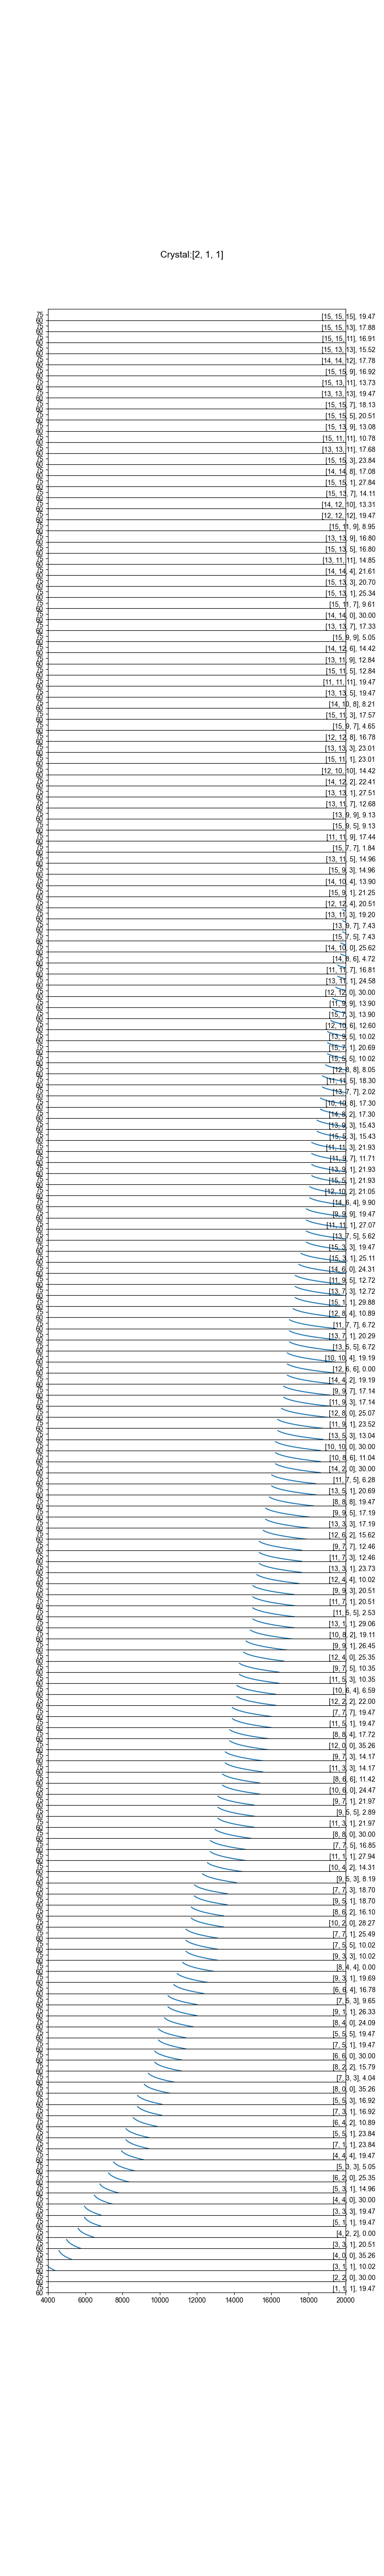

In [362]:
hkl_df=hkl_dataframe(hkl0=[2,1,1], hkl_list = ordered_hkl_list, thetaB_range = np.arange(60,85,1), figure=True, pltEmin=4000, pltEmax=20000)

In [363]:
# # This list is used by Jerry Seidler's group.
# hkl_list_1 = [[9,7,7],
#             [9,9,3],
#             [10,8,2],
#             [9,9,1],
#             [9,7,5],
#             [10,6,4],
#             [7,7,7],
#             [8,8,4],
#             [9,7,3],
#             [10,6,0],
#             [9,7,1],
#             [8,8,0],
#             [7,7,5],
#             [10,4,2],
#             [9,5,3],
#             [9,5,1],
#             [10,2,0],
#             [9,3,3],
#             [8,4,4],
#             [9,3,1],
#             [6,6,4],
#             [9,1,1],
#             [8,4,0],
#             [7,5,1],
#             [8,2,2],
#             [7,3,3],
#             [7,3,1],
#             [6,4,2],
#             [7,1,1],
#             [4,4,4],
#             ]
# hkl_df_1 = hkl_dataframe(hkl0=[2,1,1], hkl_list = hkl_list_1, thetaB_range = np.arange(60,85,1), figure=True, pltEmin=7500, pltEmax=18000)

In [364]:
# hkl_list_2 = [[5,3,1],[4,4,0],[3,3,3],[5,1,1],[4,2,2],[3,3,1],[4,0,0],[3,1,1],]
# hkl_df_2 = hkl_dataframe(hkl0=[2,1,1], hkl_list = hkl_list_2, thetaB_range = np.arange(60,85,1), figure=True, pltEmin=4000, pltEmax=8000)

In [365]:
# find_hkl(hkl0=[2,1,1], hkl_list = [[1,1,1],[5,1,1]], thetaB_range = np.arange(60,85,1), energy_val=9000, delEn=-45, delEp=25, delAlpha=30, delThetaB=10) 

# 2. Roland Circle for 1 SBCA

## HERFD Roland circle:

-Fe-----------------------
hkl=[6, 4, 2], phi=90.00
fs=534.17
theta_B=80.83, alpha=10.89, theta_M=91.72, rho=501.07
detector_x=58.89, detector_y=154.01, detector_xs=-5.96, detector_ys=168.09
----------


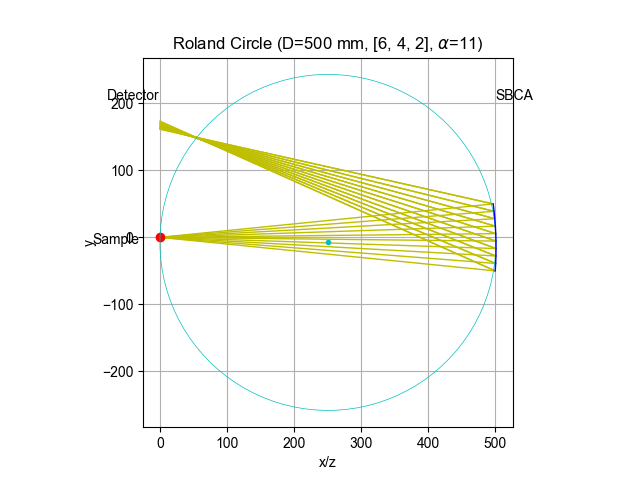

In [366]:
# No hlk, and beta value, find hkl automatically and use beta=2*alpha
print("-Fe-----------------------")
herfd_roland_circle(hkl0=[2,1,1], hkl_phi0=[1,1,1], E_emission=8652.5, hkl=None, hkl_list = ordered_hkl_list, thetaB_range = np.arange(60,85,1), delAlpha=30, deltTheB=10, beta=0, angle2beam=45, view=[120,240,-30], figure=True, reflected=True, focus=True, angle_list=True, threeD=False)
print("----------")

### Multiple emission lines

In [367]:
# # No hlk, and beta value, find hkl automatically and use beta=2*alpha
# print("-Nd La1 5227-----------------------")
# herfd_roland_circle(hkl0=[2,1,1], hkl_phi0=[1,1,1], E_emission=5227, hkl=None, hkl_list = ordered_hkl_list, thetaB_range = np.arange(60,85,1), delAlpha=30, deltTheB=10, beta=30, angle2beam=45, view=[120,240,-30], figure=True, reflected=True, focus=True, angle_list=True, threeD=False)
# print("----------")
# print("-Nd La2 5204-----------------------")
# herfd_roland_circle(hkl0=[2,1,1], hkl_phi0=[1,1,1], E_emission=5204, hkl=None, hkl_list = ordered_hkl_list, thetaB_range = np.arange(60,85,1), delAlpha=30, deltTheB=10, beta=30, angle2beam=45, view=[120,240,-30], figure=True, reflected=True, focus=True, angle_list=True, threeD=False)
# print("----------")
# print("-Pr La1 5035-----------------------")
# herfd_roland_circle(hkl0=[2,1,1], hkl_phi0=[1,1,1], E_emission=5035, hkl=None, hkl_list = ordered_hkl_list, thetaB_range = np.arange(60,85,1), delAlpha=30, deltTheB=10, beta=30, angle2beam=45, view=[120,240,-30], figure=True, reflected=True, focus=True, angle_list=True, threeD=False)
# print("----------")
# print("-Pr La2 5015-----------------------")
# herfd_roland_circle(hkl0=[2,1,1], hkl_phi0=[1,1,1], E_emission=5015, hkl=None, hkl_list = ordered_hkl_list, thetaB_range = np.arange(60,85,1), delAlpha=30, deltTheB=10, beta=30, angle2beam=45, view=[120,240,-30], figure=True, reflected=True, focus=True, angle_list=True, threeD=False)
# print("----------")
# print("-Sm La1 5632-----------------------")
# herfd_roland_circle(hkl0=[2,1,1], hkl_phi0=[1,1,1], E_emission=5632, hkl=None, hkl_list = ordered_hkl_list, thetaB_range = np.arange(60,85,1), delAlpha=30, deltTheB=10, beta=30, angle2beam=45, view=[120,240,-30], figure=True, reflected=True, focus=True, angle_list=True, threeD=False)
# print("----------")
# print("-Sm La2 5605-----------------------")
# herfd_roland_circle(hkl0=[2,1,1], hkl_phi0=[1,1,1], E_emission=5605, hkl=None, hkl_list = ordered_hkl_list, thetaB_range = np.arange(60,85,1), delAlpha=30, deltTheB=10, beta=30, angle2beam=45, view=[120,240,-30], figure=True, reflected=True, focus=True, angle_list=True, threeD=False)
# print("----------")

### Which crystal?

In [368]:
# # No hlk, and beta value, find hkl automatically and use beta=2*alpha
# crystals = [[9,1,1],[2,1,1],[7,7,3],[1,0,0],[1,1,0],[3,1,1]] # [1,1,1],
# for crys in crystals:
#     try:
#         print(f"-Crys: {crys}---for Pr La 5015-------------------")
#         herfd_roland_circle(hkl0=crys, hkl_phi0=[1,1,1], E_emission=5035, hkl=None, hkl_list = ordered_hkl_list, thetaB_range = np.arange(60,85,1), delAlpha=30, deltTheB=10, beta=0, angle2beam=45, view=[120,240,-30], figure=True, reflected=True, focus=True, angle_list=True, threeD=False)
#         print("----------")
#     except Exception as e:
#         print(f"Error with reflection {crys}: {e}")

In [369]:
# # No hlk, and beta value, find hkl automatically and use beta=2*alpha
# crystals = [[9,1,1],[2,1,1],[7,7,3],[1,0,0],[1,1,0],[3,1,1]] # [1,1,1],
# for crys in crystals:
#     try:
#         print(f"-Crys: {crys}---for Yb Lg3 10142-------------------")
#         herfd_roland_circle(hkl0=crys, hkl_phi0=[1,1,1], E_emission=10142, hkl=None, hkl_list = ordered_hkl_list, thetaB_range = np.arange(60,85,1), delAlpha=30, deltTheB=10, beta=30, angle2beam=45, view=[120,240,-30], figure=True, reflected=True, focus=True, angle_list=True, threeD=False)
#         print("----------")
#     except Exception as e:
#         print(f"Error with reflection {crys}: {e}")

In [370]:
# # No hlk, and beta value, find hkl automatically and use beta=2*alpha
# crystals = [[9,1,1],[2,1,1],[7,7,3],[1,0,0],[1,1,0],[3,1,1]] # [1,1,1],
# for crys in crystals:
#     try:
#         print(f"-Crys: {crys}---for Yb Lb3 8536-------------------")
#         herfd_roland_circle(hkl0=crys, hkl_phi0=[1,1,1], E_emission=8536, hkl=None, hkl_list = ordered_hkl_list, thetaB_range = np.arange(60,85,1), delAlpha=30, deltTheB=10, beta=30, angle2beam=45, view=[120,240,-30], figure=True, reflected=True, focus=True, angle_list=True, threeD=False)
#         print("----------")
#     except Exception as e:
#         print(f"Error with reflection {crys}: {e}")

In [371]:
# # No hlk, and beta value, find hkl automatically and use beta=2*alpha
# crystals = [[9,1,1],[2,1,1],[7,7,3],[1,1,1],[1,0,0],[1,1,0],[3,1,1]] # 
# reflections = [[3,3,3],[5,1,1],[4,2,2]]
# reflection = None
# for crys in crystals:
#     for reflection in reflections:
#         try:
#             print(f"-Crys: {crys}-Refl: {reflection}---------------------")
#             herfd_roland_circle(hkl0=crys, hkl_phi0=[1,1,1], E_emission=7478.15, hkl=None, hkl_list = ordered_hkl_list, thetaB_range = np.arange(60,85,1), delAlpha=30, deltTheB=10, beta=30, angle2beam=45, view=[120,240,-30], figure=True, reflected=True, focus=True, angle_list=True, threeD=False)
#             print("----------")
#         except Exception as e:
#             print(f"Error with reflection {crys}: {e}")

In [372]:
# # No hlk, and beta value, find hkl automatically and use beta=2*alpha
# print("-Ce-----------------------")
# herfd_roland_circle(hkl0=[2,1,1], hkl_phi0=[1,1,1], E_emission=4840.2, hkl=None, hkl_list = ordered_hkl_list, thetaB_range = np.arange(60,85,1), delAlpha=30, deltTheB=10, beta=30, angle2beam=45, view=[120,240,-30], figure=True, reflected=True, focus=True, angle_list=True, threeD=False)
# print("----------")

### Alignment

-Alignment-----------------------
hkl=[4, 4, 4], phi=0.00
fs=644.53
theta_B=70.53, alpha=19.47, theta_M=90.00, rho=501.30
detector_x=198.05, detector_y=245.07, detector_xs=0.00, detector_ys=405.12
----------


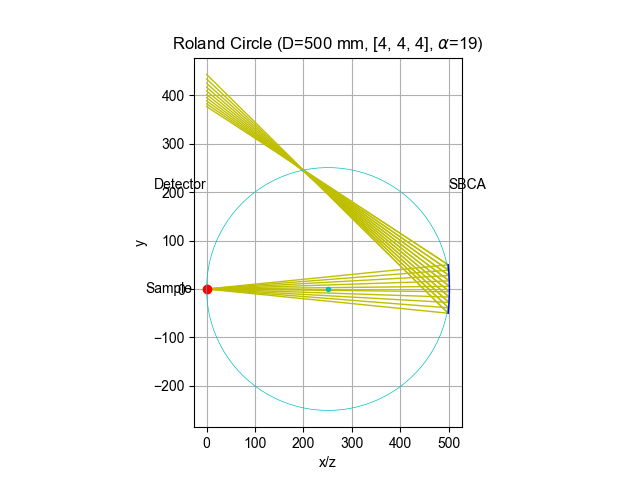

In [373]:
# No hlk, and beta value, find hkl automatically and use beta=2*alpha
print("-Alignment-----------------------")
herfd_roland_circle(hkl0=[2,1,1], hkl_phi0=[1,1,1], E_emission=8388.0, hkl=[4,4,4], hkl_list = ordered_hkl_list, thetaB_range = np.arange(60,85,1), delAlpha=30, deltTheB=10, beta=0, angle2beam=45, view=[120,240,-30], figure=True, reflected=True, focus=True, angle_list=True, threeD=False)
print("----------")

-Alignment-----------------------
hkl=[6, 4, 2], phi=90.00
fs=539.86
theta_B=79.11, alpha=10.89, theta_M=90.00, rho=501.30
detector_x=69.06, detector_y=172.77, detector_xs=0.00, detector_ys=200.37
----------


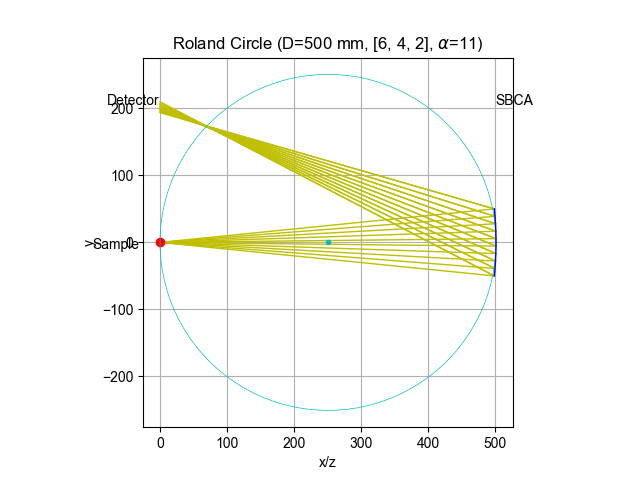

In [374]:
# No hlk, and beta value, find hkl automatically and use beta=2*alpha
print("-Alignment-----------------------")
herfd_roland_circle(hkl0=[2,1,1], hkl_phi0=[1,1,1], E_emission=8698.65, hkl=[6,4,2], hkl_list = ordered_hkl_list, thetaB_range = np.arange(60,85,1), delAlpha=30, deltTheB=10, beta=0, angle2beam=45, view=[120,240,-30], figure=True, reflected=True, focus=True, angle_list=True, threeD=False)
print("----------")

### Roland

-Alignment-----------------------
hkl=[7, 5, 3], phi=67.79
fs=530.67
theta_B=80.50, alpha=9.65, theta_M=90.15, rho=501.30
detector_x=53.94, detector_y=154.67, detector_xs=-0.47, detector_ys=172.73
----------


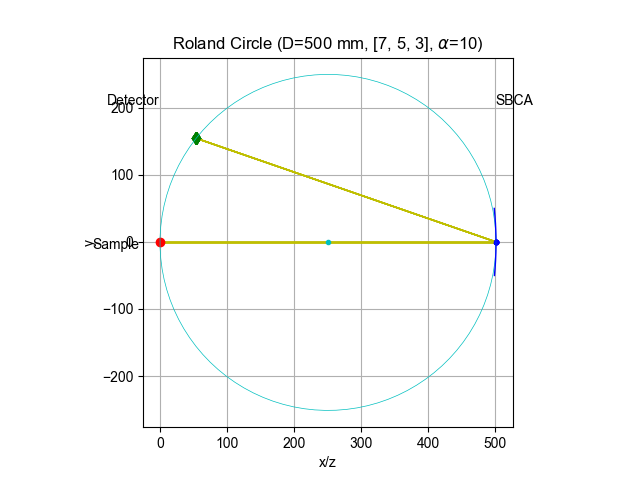

In [375]:
# No hlk, and beta value, find hkl automatically and use beta=2*alpha
print("-Alignment-----------------------")
herfd_roland_circle(hkl0=[2,1,1], hkl_phi0=[1,1,1], E_emission=10543.72, hkl=[7,5,3], hkl_list = ordered_hkl_list, thetaB_range = np.arange(60,85,1), delAlpha=30, deltTheB=10, beta=0, angle2beam=45, view=[120,240,-30], figure=True, reflected=False, focus=True, angle_list=True, threeD=False)
print("----------")

### Zn Ka1

-Zn Ka-----------------------
hkl=[6, 4, 2], phi=90.00
fs=532.62
theta_B=81.41, alpha=10.89, theta_M=92.30, rho=500.90
detector_x=55.58, detector_y=147.58, detector_xs=-7.94, detector_ys=157.36
----------


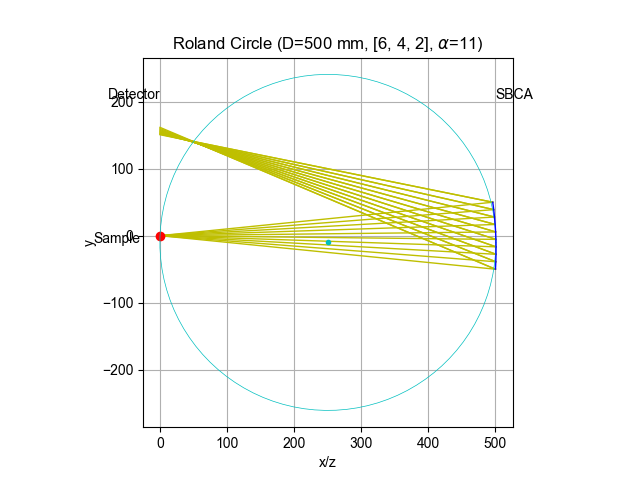

In [376]:
# No hlk, and beta value, find hkl automatically and use beta=2*alpha
print("-Zn Ka-----------------------")
herfd_roland_circle(hkl0=[2,1,1], hkl_phi0=[1,1,1], E_emission=8638.86, hkl=[6,4,2], hkl_list = ordered_hkl_list, thetaB_range = np.arange(60,85,1), delAlpha=30, deltTheB=10, beta=0, angle2beam=45, view=[120,240,-30], figure=True, reflected=True, focus=True, angle_list=True, threeD=False)
print("----------")

### Re La1

-Re La1-----------------------
hkl=[6, 4, 2], phi=90.00
fs=534.17
theta_B=80.83, alpha=10.89, theta_M=91.72, rho=501.07
detector_x=58.89, detector_y=154.01, detector_xs=-5.96, detector_ys=168.09
----------


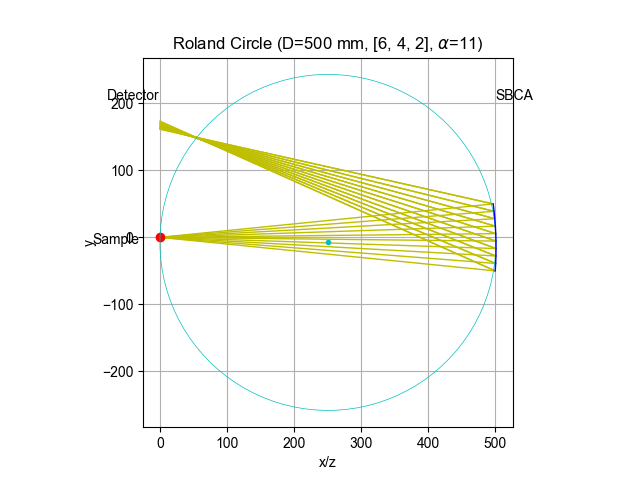

In [377]:

# No hlk, and beta value, find hkl automatically and use beta=2*alpha
print("-Re La1-----------------------")
herfd_roland_circle(hkl0=[2,1,1], hkl_phi0=[1,1,1], E_emission=8652.5, hkl=None, hkl_list = ordered_hkl_list, thetaB_range = np.arange(60,85,1), delAlpha=30, deltTheB=10, beta=0, angle2beam=45, view=[120,240,-30], figure=True, reflected=True, focus=True, angle_list=True, threeD=False)
print("----------")

### As Ka1

-As Ka1-----------------------
hkl=[7, 5, 3], phi=67.79
fs=530.67
theta_B=80.50, alpha=9.65, theta_M=90.15, rho=501.30
detector_x=53.94, detector_y=154.67, detector_xs=-0.47, detector_ys=172.73
----------


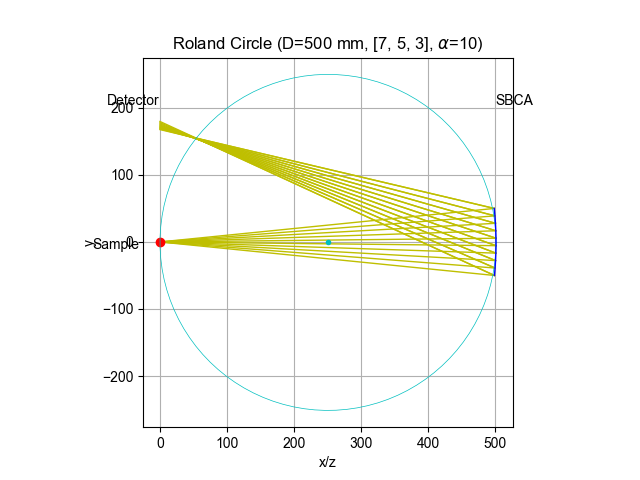

In [378]:

# No hlk, and beta value, find hkl automatically and use beta=2*alpha
print("-As Ka1-----------------------")
herfd_roland_circle(hkl0=[2,1,1], hkl_phi0=[1,1,1], E_emission=10543.72, hkl=None, hkl_list = ordered_hkl_list, thetaB_range = np.arange(60,85,1), delAlpha=30, deltTheB=10, beta=0, angle2beam=45, view=[120,240,-30], figure=True, reflected=True, focus=True, angle_list=True, threeD=False)
print("----------")

### Cu Ka1

-Cu Ka1-----------------------
hkl=[4, 4, 4], phi=0.00
fs=593.95
theta_B=79.32, alpha=19.47, theta_M=98.79, rho=495.42
detector_x=123.56, detector_y=179.46, detector_xs=-57.71, detector_ys=216.41
----------


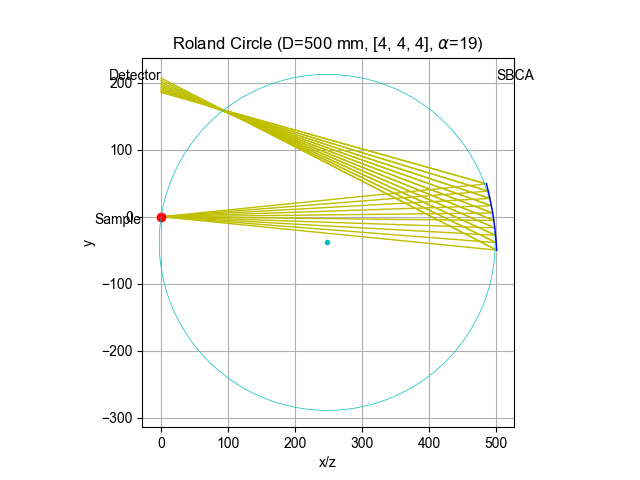

In [379]:

# No hlk, and beta value, find hkl automatically and use beta=2*alpha
print("-Cu Ka1-----------------------")
herfd_roland_circle(hkl0=[2,1,1], hkl_phi0=[1,1,1], E_emission=8047.78, hkl=None, hkl_list = ordered_hkl_list, thetaB_range = np.arange(60,85,1), delAlpha=30, deltTheB=10, beta=0, angle2beam=45, view=[120,240,-30], figure=True, reflected=True, focus=True, angle_list=True, threeD=False)
print("----------")

In [380]:
measured = theta_bragg(7515.85-2, hkl=[5,3,3])
reference = theta_bragg(7514.2, hkl=[5,3,3])
offset = measured - reference
print(f'measured={measured:.3f}')
print(f'reference={reference:.3f}')
print(f'del_thetaB ={offset:.3f}')

measured=84.982
reference=84.952
del_thetaB =0.030


In [381]:
cal_alpha([2,1,1],[5,3,3])


5.051152528017831

In [382]:
energy_JNA = energy(90-cal_alpha([2,1,1],[5,3,3]), hkl=[5,3,3])
print(f'energy_JNA={energy_JNA:.2f}')

energy_JNA=7514.23


### Pt La1

-Pt La1-----------------------
hkl=[7, 3, 3], phi=180.00
fs=516.04
theta_B=81.69, alpha=4.04, theta_M=85.74, rho=499.91
detector_x=22.24, detector_y=123.37, detector_xs=5.41, detector_ys=147.54
----------


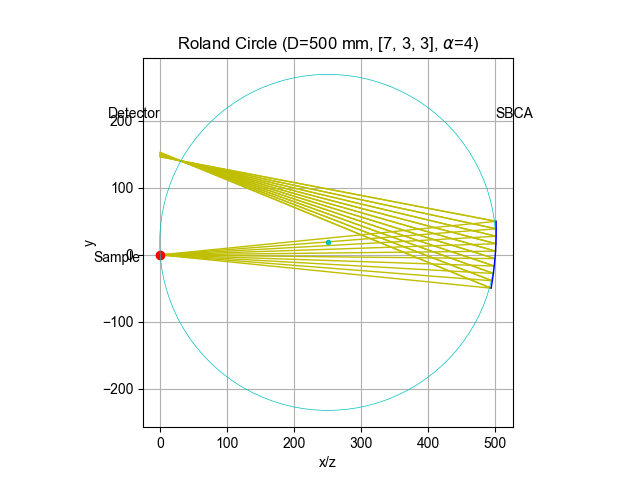

In [383]:
# No hlk, and beta value, find hkl automatically and use beta=2*alpha
print("-Pt La1-----------------------")
herfd_roland_circle(hkl0=[2,1,1], hkl_phi0=[1,1,1], E_emission=9442.3, hkl=[7,3,3], hkl_list = ordered_hkl_list, thetaB_range = np.arange(60,85,1), delAlpha=30, deltTheB=10, beta=0, angle2beam=45, view=[120,240,-30], figure=True, reflected=True, focus=True, angle_list=True, threeD=False)
print("----------")

### Au La1

-Au La1-----------------------
hkl=[5, 5, 3], phi=39.23
fs=659.17
theta_B=67.17, alpha=16.92, theta_M=84.09, rho=498.64
detector_x=203.72, detector_y=272.28, detector_xs=38.01, detector_ys=471.52
----------


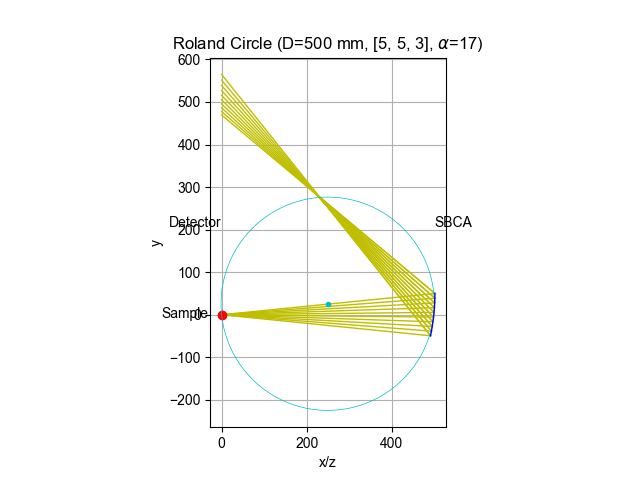

In [384]:
# No hlk, and beta value, find hkl automatically and use beta=2*alpha
print("-Au La1-----------------------")
herfd_roland_circle(hkl0=[2,1,1], hkl_phi0=[1,1,1], E_emission=9513.3, hkl=[5,5,3], hkl_list = ordered_hkl_list, thetaB_range = np.arange(60,85,1), delAlpha=30, deltTheB=10, beta=0, angle2beam=45, view=[120,240,-30], figure=True, reflected=True, focus=True, angle_list=True, threeD=False)
print("----------")

## RIXS Roland circle moving

hkl=[5, 5, 5], phi=0.00
fs=597.84
theta_B=78.06, alpha=19.47, theta_M=97.53, rho=496.98
detector_x=134.02, detector_y=190.14, detector_xs=-49.67, detector_ys=242.05
fs=600.78
theta_B=77.28, alpha=19.47, theta_M=96.75, rho=497.82
detector_x=140.53, detector_y=196.54, detector_xs=-44.71, detector_ys=258.05
fs=603.91
theta_B=76.55, alpha=19.47, theta_M=96.02, rho=498.53
detector_x=146.67, detector_y=202.39, detector_xs=-40.05, detector_ys=273.19


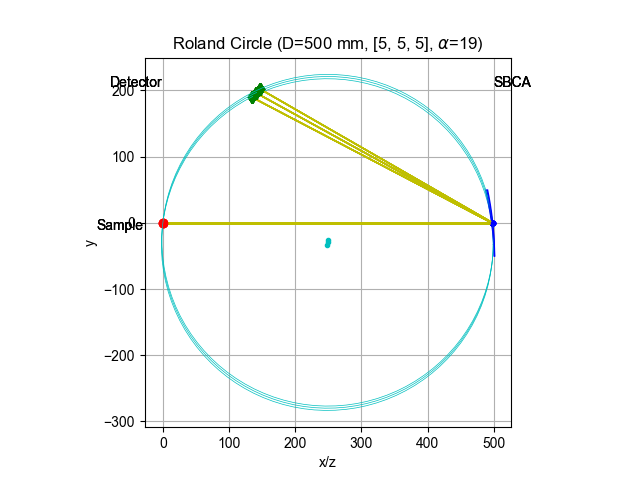

In [405]:
# No hlk, and beta value, find hkl automatically and use beta=2*alpha
rixs_roland_circles(hkl0=[2,1,1], hkl_phi0=[1,1,1], E_emission=10134, delEn=-30, delEp=31, E_step=30, hkl=[5,5,5], hkl_list = ordered_hkl_list, delAlpha=30, deltTheB=10, beta=0, reflected=False, focus=False, angle_list=True)

hkl=[5, 5, 3], phi=39.23
fs=570.39
theta_B=80.11, alpha=16.92, theta_M=97.03, rho=497.53
detector_x=100.13, detector_y=171.13, detector_xs=-39.20, detector_ys=193.04
fs=570.85
theta_B=79.93, alpha=16.92, theta_M=96.85, rho=497.72
detector_x=101.52, detector_y=172.87, detector_xs=-38.20, detector_ys=196.62
fs=571.33
theta_B=79.75, alpha=16.92, theta_M=96.67, rho=497.91
detector_x=102.88, detector_y=174.57, detector_xs=-37.22, detector_ys=200.14
fs=571.82
theta_B=79.57, alpha=16.92, theta_M=96.50, rho=498.08
detector_x=104.23, detector_y=176.23, detector_xs=-36.26, detector_ys=203.60
fs=572.32
theta_B=79.40, alpha=16.92, theta_M=96.32, rho=498.25
detector_x=105.55, detector_y=177.85, detector_xs=-35.32, detector_ys=207.01
fs=572.83
theta_B=79.23, alpha=16.92, theta_M=96.15, rho=498.41
detector_x=106.85, detector_y=179.44, detector_xs=-34.39, detector_ys=210.36
fs=573.35
theta_B=79.06, alpha=16.92, theta_M=95.98, rho=498.57
detector_x=108.14, detector_y=181.00, detector_xs=-33.48, detecto

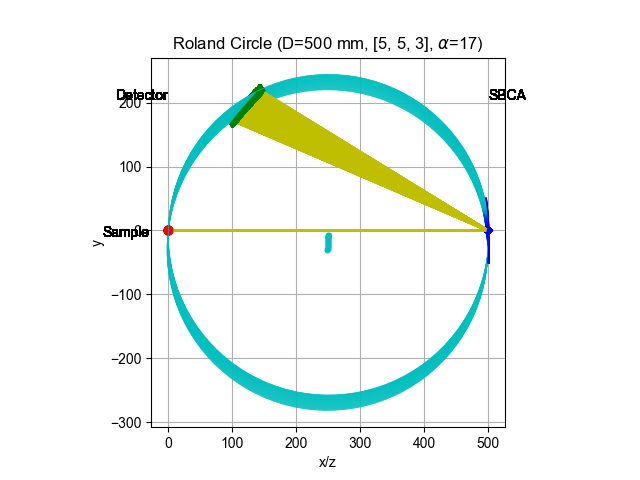

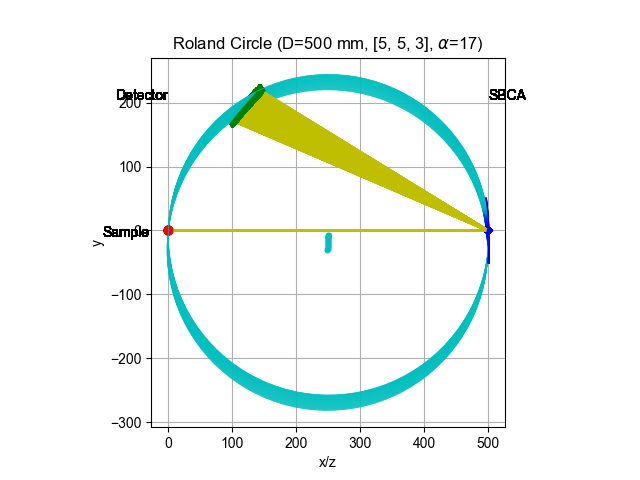

In [407]:
# No hlk, and beta value, find hkl automatically and use beta=2*alpha
rixs_roland_circles(hkl0=[2,1,1], hkl_phi0=[1,1,1], E_emission=9000, delEn=-100, delEp=100, E_step=5, hkl=None, hkl_list = ordered_hkl_list, delAlpha=30, deltTheB=10, beta=0, reflected=False, focus=False, angle_list=True)
# herfd_roland_circle(hkl0=[2,1,1], hkl=[5,5,3], E_emission=9000, beta=30, angle2beam=45, view=[120,240,-30], figure=True, reflected=True, focus=True, angle_list=False, threeD=False)
rixs_roland_circles(hkl0=[2,1,1], hkl_phi0=[1,1,1], E_emission=9000, delEn=-100, delEp=100, E_step=5, hkl=[5,5,3], hkl_list = ordered_hkl_list, delAlpha=30, deltTheB=10, beta=0, reflected=False, focus=False, angle_list=True)


# 3. Alpha-Phi plot 

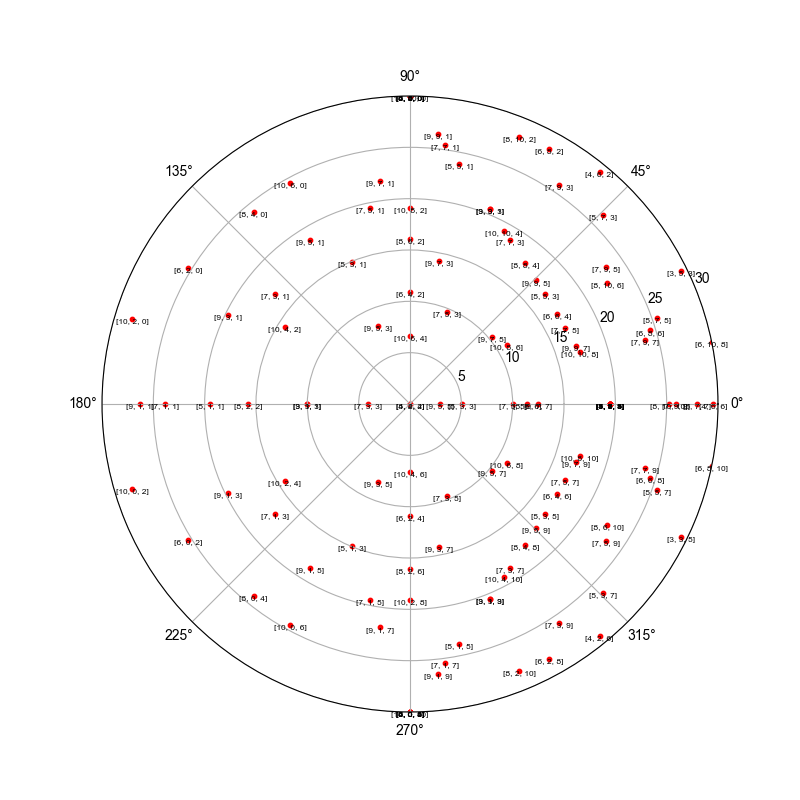

In [387]:
alpha_phi_scan = AlphaPhiScan()
fig, ax = alpha_phi_scan.visualize_alphi(num_points=0, pt_density=0.1, alpha_max=30, hkl0=[2,1,1], hkl_phi0=[1,1,1], hkl_list_phi=ordered_hkl_list_phi)
plt.show()

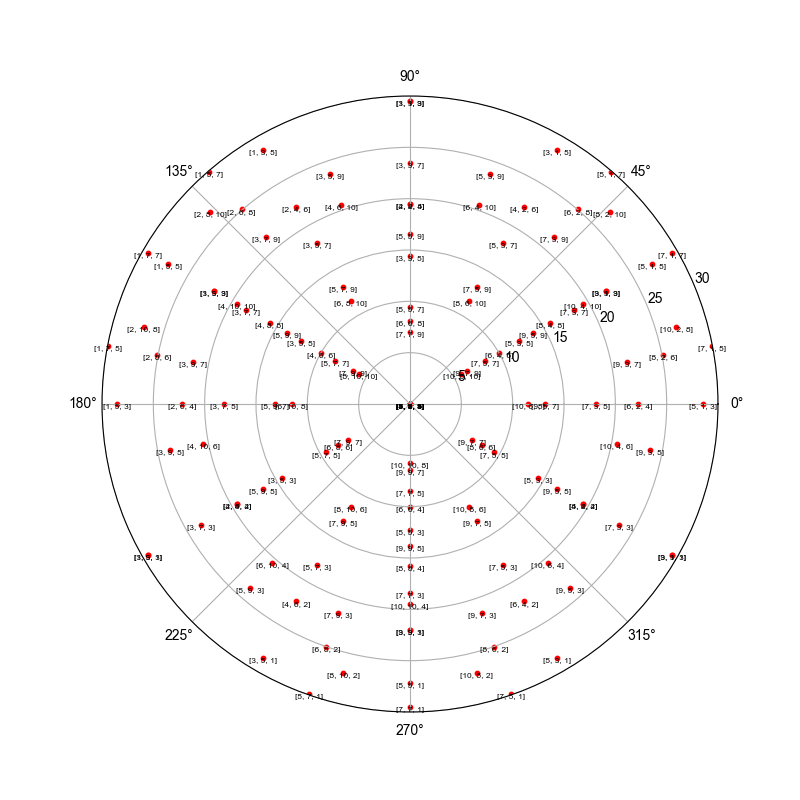

In [388]:
alpha_phi_scan = AlphaPhiScan()
fig, ax = alpha_phi_scan.visualize_alphi(num_points=0, pt_density=0.1, alpha_max=30, hkl0=[1,1,1], hkl_phi0=[1,-1,0], hkl_list_phi=ordered_hkl_list_phi)
plt.show()

# 4. Crystal selection

## Calculate

In [389]:
# Read and flatten emission lines
emission = pd.read_csv("EmissionLine.csv", index_col=False)
# Detect which emission columns are present (excluding 'Element')
emission_columns = [col for col in emission.columns if col != "Element"]

# Flatten available emission lines
emission_lines = []
for _, row in emission.iterrows():
    element = row["Element"]
    for line in emission_columns:
        if pd.notnull(row[line]):
            emission_lines.append({
                "Element": element,
                "Emission": line,
                "Energy": row[line]
            })

# Create the DataFrame
df_emission_lines = pd.DataFrame(emission_lines)

In [390]:
# Set up crystals and compute geometry
# crystals = [[2,1,1],[7,7,3],[1,1,1],[1,0,0],[9,1,1],[1,1,0],[3,1,1]]
crystals = [[2,1,1],[5,3,3],[6,4,2]]
geometry_list = []

for emis_row in df_emission_lines.itertuples():
    for crys in crystals:
        crys_dic = {
            "Element": emis_row.Element,
            "Emission": emis_row.Emission,
            "Energy": emis_row.Energy,
            "Crystal": crys
        }
        try:
            if crys == [1,1,1]:
                geometry_dic = herfd_roland_circle(hkl0=crys, hkl_phi0=[1,-1,0], E_emission=emis_row.Energy, hkl=None, hkl_list = ordered_hkl_list, thetaB_range = np.arange(60,85,1), delAlpha=30, deltTheB=10, beta=None, angle2beam=45, view=[120,240,-30], figure=False, reflected=True, focus=True, angle_list=False, threeD=False)
            else:
                geometry_dic = herfd_roland_circle(hkl0=crys, hkl_phi0=[1,1,1], E_emission=emis_row.Energy, hkl=None, hkl_list = ordered_hkl_list, thetaB_range = np.arange(60,85,1), delAlpha=30, deltTheB=10, beta=None, angle2beam=45, view=[120,240,-30], figure=False, reflected=True, focus=True, angle_list=False, threeD=False)
            geometry = crys_dic | geometry_dic
            geometry_list.append(geometry)
        except Exception as e:
            print(f"Error with Element={emis_row.Element}, Emission={emis_row.Emission}, Energy={emis_row.Energy}, hkl={crys}: {e}")

# Save to CSV
df = pd.DataFrame(geometry_list)
df.to_csv("Herfd_geometry.csv", index=False)


fs=622.21
fs=640.65
fs=638.93
Error with Element=Sc, Emission=[6,4,2], Energy=x, hkl=[2, 1, 1]: can only concatenate str (not "int") to str
Error with Element=Sc, Emission=[6,4,2], Energy=x, hkl=[5, 3, 3]: can only concatenate str (not "int") to str
Error with Element=Sc, Emission=[6,4,2], Energy=x, hkl=[6, 4, 2]: can only concatenate str (not "int") to str
Error with Element=Sc, Emission=[5,3,3], Energy=x, hkl=[2, 1, 1]: can only concatenate str (not "int") to str
Error with Element=Sc, Emission=[5,3,3], Energy=x, hkl=[5, 3, 3]: can only concatenate str (not "int") to str
Error with Element=Sc, Emission=[5,3,3], Energy=x, hkl=[6, 4, 2]: can only concatenate str (not "int") to str
Error with Element=Ti, Emission=Ka1, Energy=4510.84, hkl=[2, 1, 1]: 'theta_B'
Error with Element=Ti, Emission=Ka1, Energy=4510.84, hkl=[5, 3, 3]: 'theta_B'
Error with Element=Ti, Emission=Ka1, Energy=4510.84, hkl=[6, 4, 2]: 'theta_B'
fs=996.04
fs=1230.78
fs=1051.75
fs=695.55
fs=682.27
fs=636.72
fs=595.98
fs=5

In [391]:
# Filter only rows with HERFD_Vert > -40
df_sel = df[(df["HERFD_Vert"] > -100) & (df["HERFD_Vert"] < 400)]
#df = df[(df["HERFD_Vert"] > -40) & (df["HERFD_Vert"] < 60)] #& (df["Det_Vert"] > 130)

# Save to CSV
df_sel.to_csv("herfd_geometry_selected.csv", index=False)

# df["Crystal"] = df["Crystal"].apply(tuple)  # Convert lists to tuples
# crystal_counts = df["Crystal"].value_counts()
# print(crystal_counts)


In [392]:
# Given list of crystals
crystals = [[2,1,1], [7,7,3], [1,1,1], [1,0,0], [9,1,1], [1,1,0], [3,1,1]]

# Generate all possible combinations of 3 crystals
combinations_of_3 = list(itertools.combinations(crystals, 3))

all_elem = df_emission_lines["Element"]

min_missing = float('inf')
best_comb = None
best_missing_elems = []

for comb in combinations_of_3:
    print(comb[0],comb[1],comb[2])
    combined_elements = pd.Series(dtype=object)  # Initialize empty Series
    for n in range(3):        
        sel_hkl = df_sel[df_sel["Crystal"].apply(lambda x: x==comb[n])]
        sel_hkl_elem = sel_hkl["Element"]
        combined_elements = pd.concat([combined_elements, sel_hkl_elem])
    combined_elements = combined_elements.drop_duplicates().reset_index(drop=True)
    # Elements only in the full dataset, not in any subset
    elem_not_in_any = all_elem[~all_elem.isin(combined_elements)].drop_duplicates().reset_index(drop=True)
    print(f"Missing elements ({len(elem_not_in_any)}):", elem_not_in_any.tolist())
    print("-" * 50)

    if len(elem_not_in_any) < min_missing:
        min_missing = len(elem_not_in_any)
        best_comb = comb
        best_missing_elems = elem_not_in_any.tolist()

# Output best combination
print("Best combination:", best_comb)
print(f"Missing elements ({min_missing}):", best_missing_elems)


[2, 1, 1] [7, 7, 3] [1, 1, 1]
Missing elements (2): ['Ti', 'Ba']
--------------------------------------------------
[2, 1, 1] [7, 7, 3] [1, 0, 0]
Missing elements (2): ['Ti', 'Ba']
--------------------------------------------------
[2, 1, 1] [7, 7, 3] [9, 1, 1]
Missing elements (2): ['Ti', 'Ba']
--------------------------------------------------
[2, 1, 1] [7, 7, 3] [1, 1, 0]
Missing elements (2): ['Ti', 'Ba']
--------------------------------------------------
[2, 1, 1] [7, 7, 3] [3, 1, 1]
Missing elements (2): ['Ti', 'Ba']
--------------------------------------------------
[2, 1, 1] [1, 1, 1] [1, 0, 0]
Missing elements (2): ['Ti', 'Ba']
--------------------------------------------------
[2, 1, 1] [1, 1, 1] [9, 1, 1]
Missing elements (2): ['Ti', 'Ba']
--------------------------------------------------
[2, 1, 1] [1, 1, 1] [1, 1, 0]
Missing elements (2): ['Ti', 'Ba']
--------------------------------------------------
[2, 1, 1] [1, 1, 1] [3, 1, 1]
Missing elements (2): ['Ti', 'Ba']
-------

In [393]:
# Ensure correct column names
all_elem = df_emission_lines["Element"]

# Given list of crystals
crystals = [[2,1,1], [7,7,3], [1,1,1], [1,0,0], [9,1,1], [1,1,0], [3,1,1]]

# Generate all possible combinations of 3 crystals
combinations_of_3 = list(itertools.combinations(crystals, 3))

results = []

for comb in combinations_of_3:
    combined_elements = pd.Series(dtype=object)

    for hkl in comb:
        sel_hkl = df_sel[df_sel["Crystal"].apply(lambda x: x==hkl)]
        sel_hkl_elem = sel_hkl["Element"]
        combined_elements = pd.concat([combined_elements, sel_hkl_elem])

    combined_elements = combined_elements.drop_duplicates().reset_index(drop=True)
    elem_not_in_any = all_elem[~all_elem.isin(combined_elements)].drop_duplicates().reset_index(drop=True)

    results.append({
        "combination": str(comb),
        "missing_count": len(elem_not_in_any),
        "missing_elements": ", ".join(elem_not_in_any.tolist())
    })

# Sort results by missing_count (ascending) and save top 5
results_sorted = sorted(results, key=lambda x: x["missing_count"])
results_df = pd.DataFrame(results_sorted)
results_df.to_csv("Any3Crystals.csv", index=False)

## Setup Plot

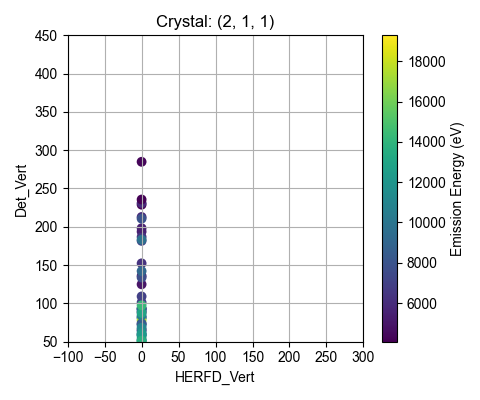

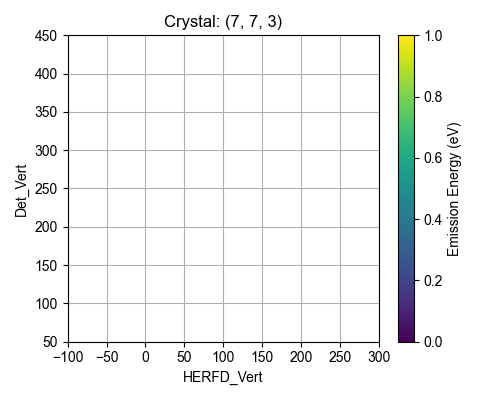

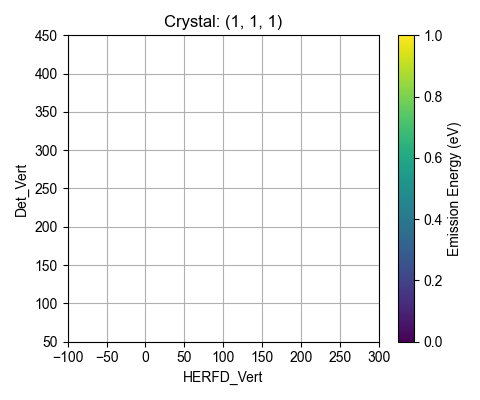

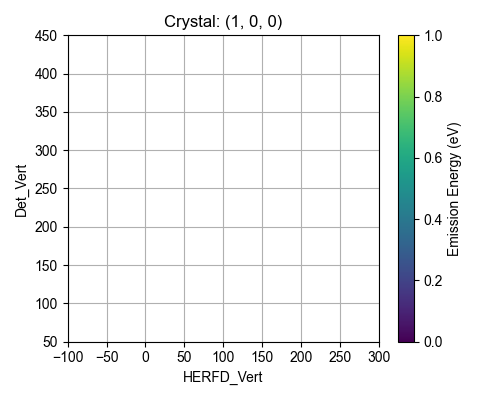

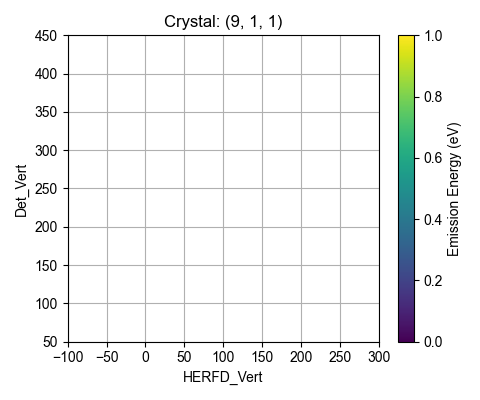

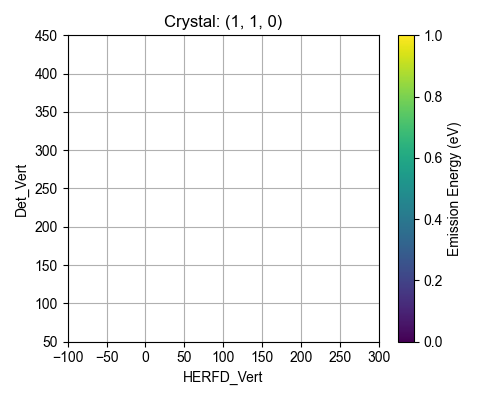

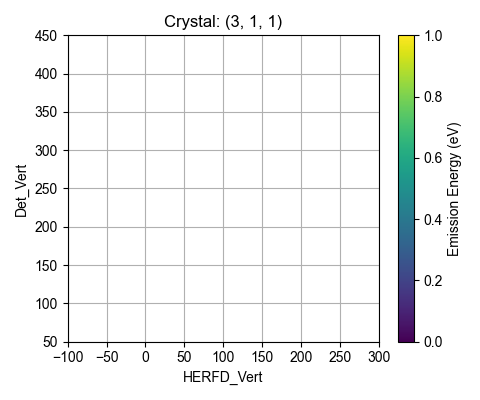

In [394]:
# plot axis limit
HERFDVmin,HERFDVmax=(-100,300) # --> x axis
DetVmin,DetVmax=(50,450) # --> y axis
# Convert Crystal column to tuple if not already
df["Crystal"] = df["Crystal"].apply(lambda x: tuple(x) if isinstance(x, list) else x)
crystals = [tuple(c) for c in crystals]

for crystal in crystals:
    subset = df[df["Crystal"] == crystal]
    
    plt.figure(figsize=((HERFDVmax-HERFDVmin)/100*1.2, (DetVmax-DetVmin)/100))
    # plt.scatter(subset["HERFD_Vert"], subset["Det_Vert"], c='blue', edgecolors='k')
    scatter = plt.scatter(subset["HERFD_Vert"], subset["Det_Vert"],
                          c=subset["Energy"], cmap='viridis',
                          edgecolors='none', s=50)
    cbar = plt.colorbar(scatter)
    cbar.set_label("Emission Energy (eV)")
    plt.xlim(HERFDVmin, HERFDVmax)
    plt.ylim(50, 450)
    plt.xlabel("HERFD_Vert")
    plt.ylabel("Det_Vert")
    plt.title(f"Crystal: {crystal}")
    plt.grid(True)
    plt.xticks(range(HERFDVmin, HERFDVmax+1, 50))
    plt.yticks(range(DetVmin, DetVmax+1, 50))
    plt.tight_layout()
    plt.show()
    # filename = f"Crystal_{'_'.join(map(str, crystal))}.pdf"
    filename = f"Crystal_{'_'.join(map(str, crystal))}_energy_colored.pdf"
    plt.savefig(filename) 
 


In [395]:
# thetaM = [88, 96]

# crystals = [[2,1,1],[7,7,3],[1,1,1],[1,0,0],[9,1,1],[1,1,0],[3,1,1]]

# for crystal in crystals:
#     print(crystal)
#     for plane in ordered_hkl_list:
#         print(plane)
#         alpha = cal_alpha(hkl1=crystal, hkl2=plane)
#         theta_bragg=[thetaM[0]-alpha, thetaM[1]-alpha]
#         E_high=energy(theta_bragg[0], hkl=[4,4,4])
#         print(E_high)
#         E_low=energy(theta_bragg[1], hkl=[4,4,4])
#         print(E_low)
#         print("__")
#     print("______________")

## Elergy Plot

In [396]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches

# def hkl_dataframe_thetaM(
#     hkl0=[2, 1, 1],
#     hkl_list=[[111], [311]],
#     theta_M_bins=[(88, 90), (90, 92), (92, 94), (94, 96)],
#     figure=True,
#     pltEmin=3000,
#     pltEmax=18000,
#     fig_title=None
# ):
#     hkl_data = []

#     # Color map for theta_M ranges
#     color_map = {
#         (88, 90): 'blue',
#         (90, 92): 'cyan',
#         (92, 94): 'khaki',
#         (94, 96): 'red'
#     }

#     for theta_min, theta_max in theta_M_bins:
#         theta_M_range = np.arange(theta_min, theta_max, 0.1)
#         for hkl in hkl_list:
#             alpha_val = cal_alpha(hkl0, hkl)
#             thetaB_range = theta_M_range - alpha_val
#             energy_range = [energy(theta, hkl) for theta in thetaB_range]
#             Emin = min(energy_range)
#             Emax = max(energy_range)
#             hkl_data.append({
#                 'hkl': tuple(hkl),  # use tuple for grouping
#                 'alpha': alpha_val,
#                 'Emin': Emin / 1000,
#                 'Emax': Emax / 1000,
#                 'theta_M': theta_min,
#                 'theta_M_bin': f"{theta_min}–{theta_max}",
#                 'color': color_map[(theta_min, theta_max)]
#             })

#     hkl_df = pd.DataFrame(hkl_data)
#     # Unique HKLs and consistent vertical positions
#     unique_hkls = sorted(hkl_df['hkl'].unique(), key=lambda x: hkl_list.index(list(x)))
#     # Reverse hkl_list and convert to tuple for consistency with hkl_df['hkl']
#     unique_hkls = [tuple(hkl) for hkl in hkl_list[::-1]]

#     if figure:
#         fig, ax = plt.subplots(figsize=(10, len(unique_hkls) * 0.5))
#         y_labels = []
#         y_pos = []

#         for i, hkl in enumerate(unique_hkls):
#             hkl_rows = hkl_df[hkl_df['hkl'] == hkl]
#             for _, row in hkl_rows.iterrows():
#                 ax.barh(i, row['Emax'] - row['Emin'], left=row['Emin'], height=0.4,
#                         color=row['color'], edgecolor=row['color'])

#             y_labels.append(f"{list(hkl)}, {row['alpha']:.1f}")
#             y_pos.append(i)

#         ax.set_yticks(y_pos)
#         ax.set_yticklabels(y_labels, fontsize=8)
#         ax.set_xlabel("Energy (keV)", fontsize=12, fontname="Arial")
#         ax.set_xlim(pltEmin / 1000, pltEmax / 1000)

#         # Title
#         full_title = f"Crystal: {hkl0}"
#         if fig_title:
#             full_title = f"{fig_title}\n{full_title}"
#         ax.set_title(full_title, fontsize=14, fontname="Arial", pad=20)

#         # Legend
#         legend_patches = [
#             mpatches.Patch(color='blue', label='88–90'),
#             mpatches.Patch(color='cyan', label='90–92'),
#             mpatches.Patch(color='khaki', label='92–94'),
#             mpatches.Patch(color='red', label='94–96')
#         ]
#         ax.legend(handles=legend_patches, title="Theta_M Range", loc='upper left')

#         plt.tight_layout()
#         plt.show()
        
#         filename = f"Crystal_{'_'.join(map(str, crystal))}_energy_range_colored.pdf"
#         plt.savefig(filename) 

#     return hkl_df

In [397]:
# crystals = [[2,1,1],[7,7,3],[1,1,1],[1,0,0],[9,1,1],[1,1,0],[3,1,1]]
# ordered_hkl_list = order_hkl_by_sum_of_squares(generate_hkl(15))
# for crystal in crystals:
#     hkl_df=hkl_dataframe_thetaM(hkl0=crystal, hkl_list = ordered_hkl_list, theta_M_bins=[(88, 90),(90, 92),(92, 94),(94, 96)], figure=True, pltEmin=4000, pltEmax=20000, fig_title=None)

In [398]:
def hkl_dataframe_thetaM(hkl0=[2, 1, 1], hkl_list=[[111], [311]], theta_M_range=np.arange(88, 96, 1), figure=True, pltEmin=4000, pltEmax=20000, fig_title=None):
    hkl_data = []

    for hkl in hkl_list:
        alpha_val = cal_alpha(hkl0, hkl)
        thetaB_range = theta_M_range - alpha_val
        energy_range = [energy(theta, hkl) for theta in thetaB_range]
        Emin = min(energy_range)
        Emax = max(energy_range)
        hkl_data.append({
            'hkl': hkl,
            'alpha': alpha_val,
            'Emin': Emin / 1000,  # convert to keV
            'Emax': Emax / 1000,
        })

    hkl_df = pd.DataFrame(hkl_data)

    # Reverse order so first HKL appears at the bottom
    hkl_df = hkl_df.iloc[::-1].reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(10, len(hkl_df) * 0.3))
    y_labels = []
    y_pos = []

    for i, row in hkl_df.iterrows():
        hkl_label = f"{row['hkl']}, {row['alpha']:.1f}"
        ax.barh(i, row['Emax'] - row['Emin'], left=row['Emin'], height=0.6,
                color='blue', edgecolor='blue')
        y_labels.append(hkl_label)
        y_pos.append(i)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_labels, fontsize=8)
    ax.set_xlabel("Energy (keV)", fontsize=12, fontname="Arial")
    ax.set_xlim(pltEmin / 1000, pltEmax / 1000)

    # Set the figure title using hkl0
    full_title = f"Crystal: {hkl0}"
    if fig_title:
        full_title = f"{fig_title}\n{full_title}"
    ax.set_title(full_title, fontsize=14, fontname="Arial", pad=20)

    plt.tight_layout()
    plt.show()
    filename = f"Crystal_{'_'.join(map(str, crystal))}_energy_range.pdf"
    plt.savefig(filename) 

    return hkl_df

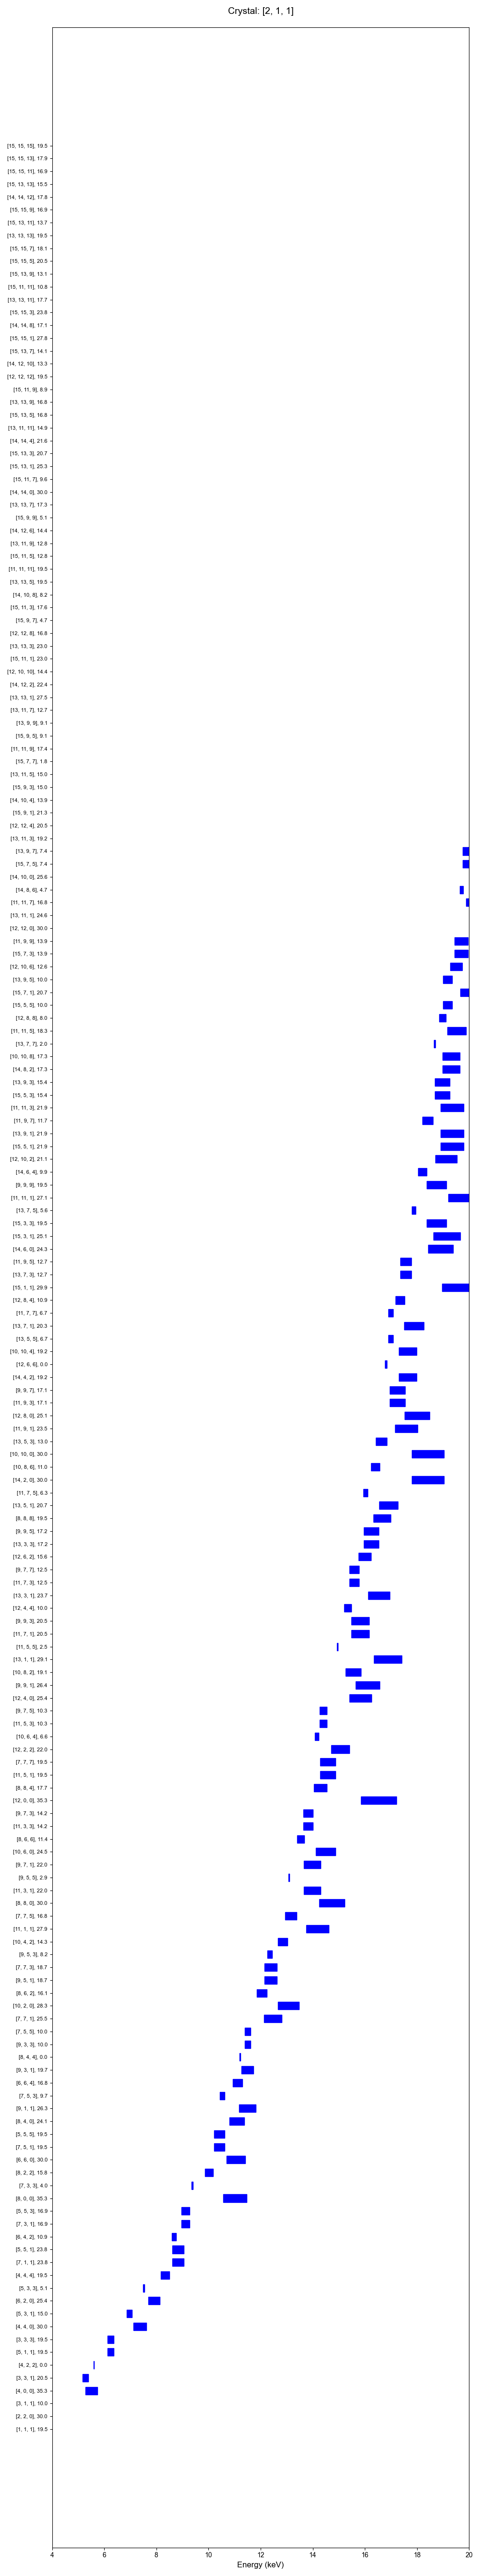

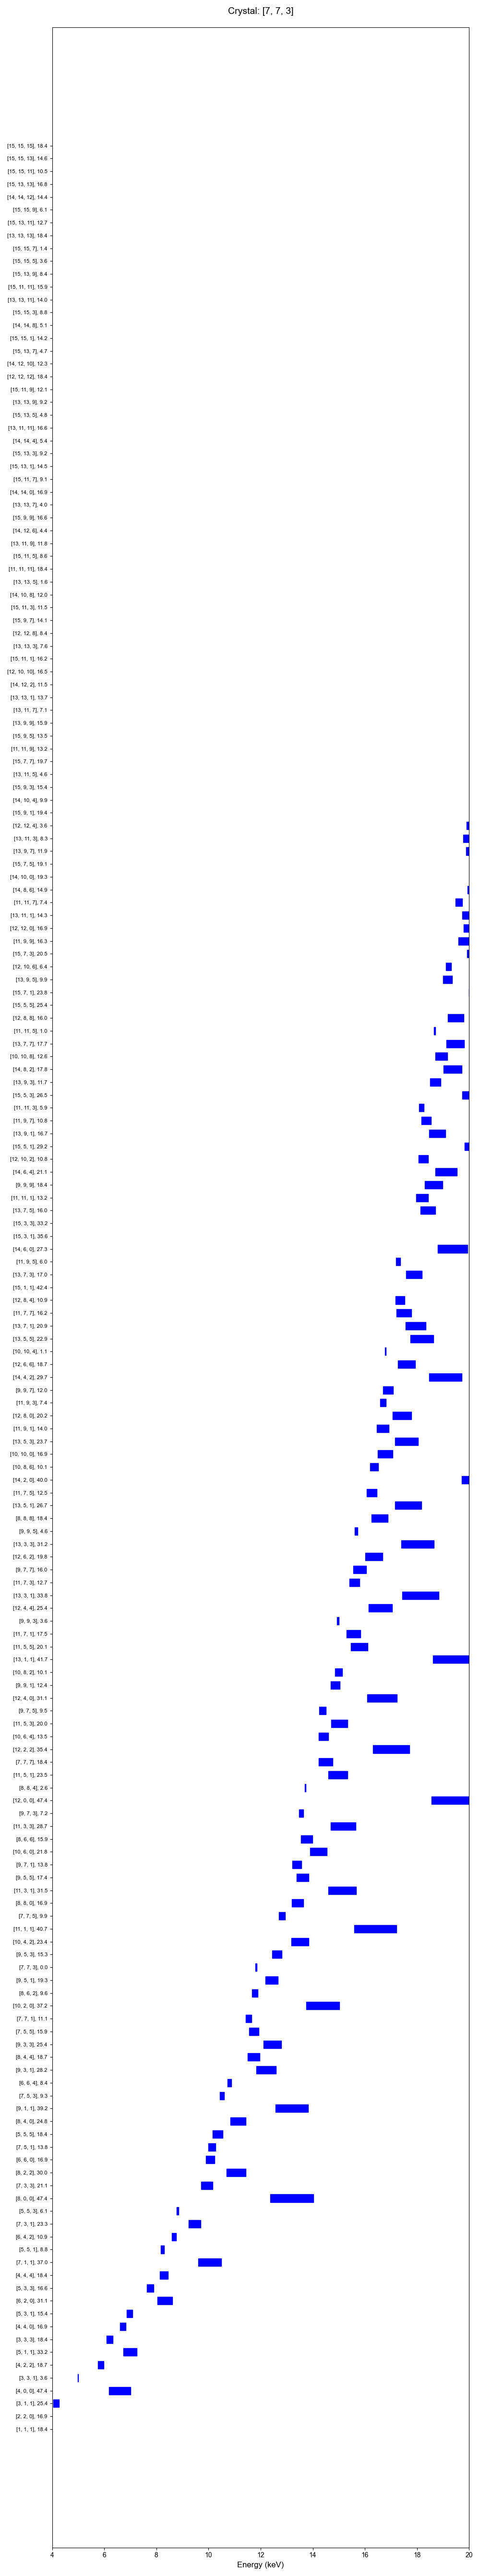

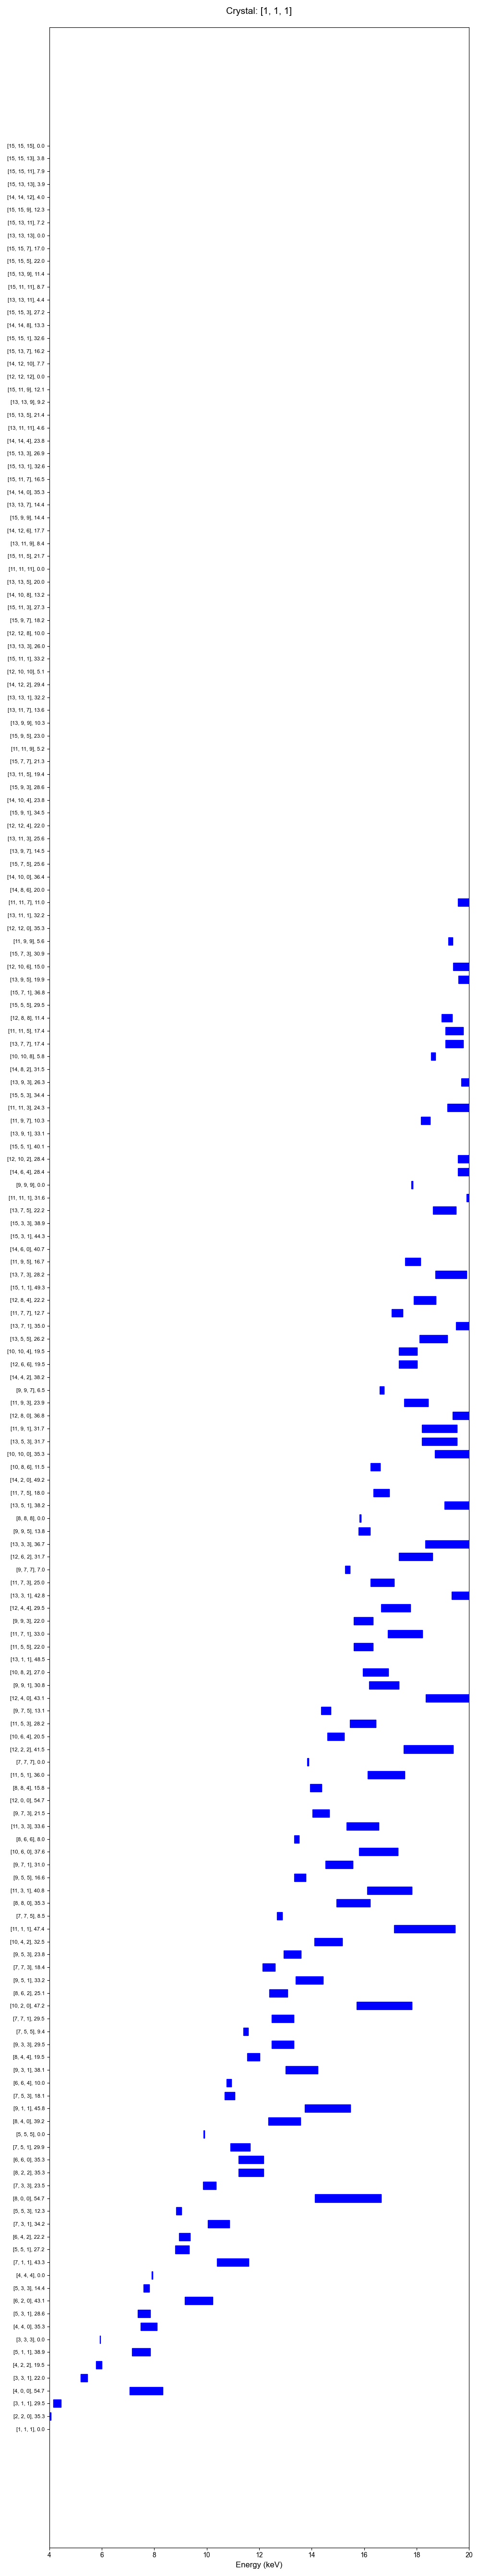

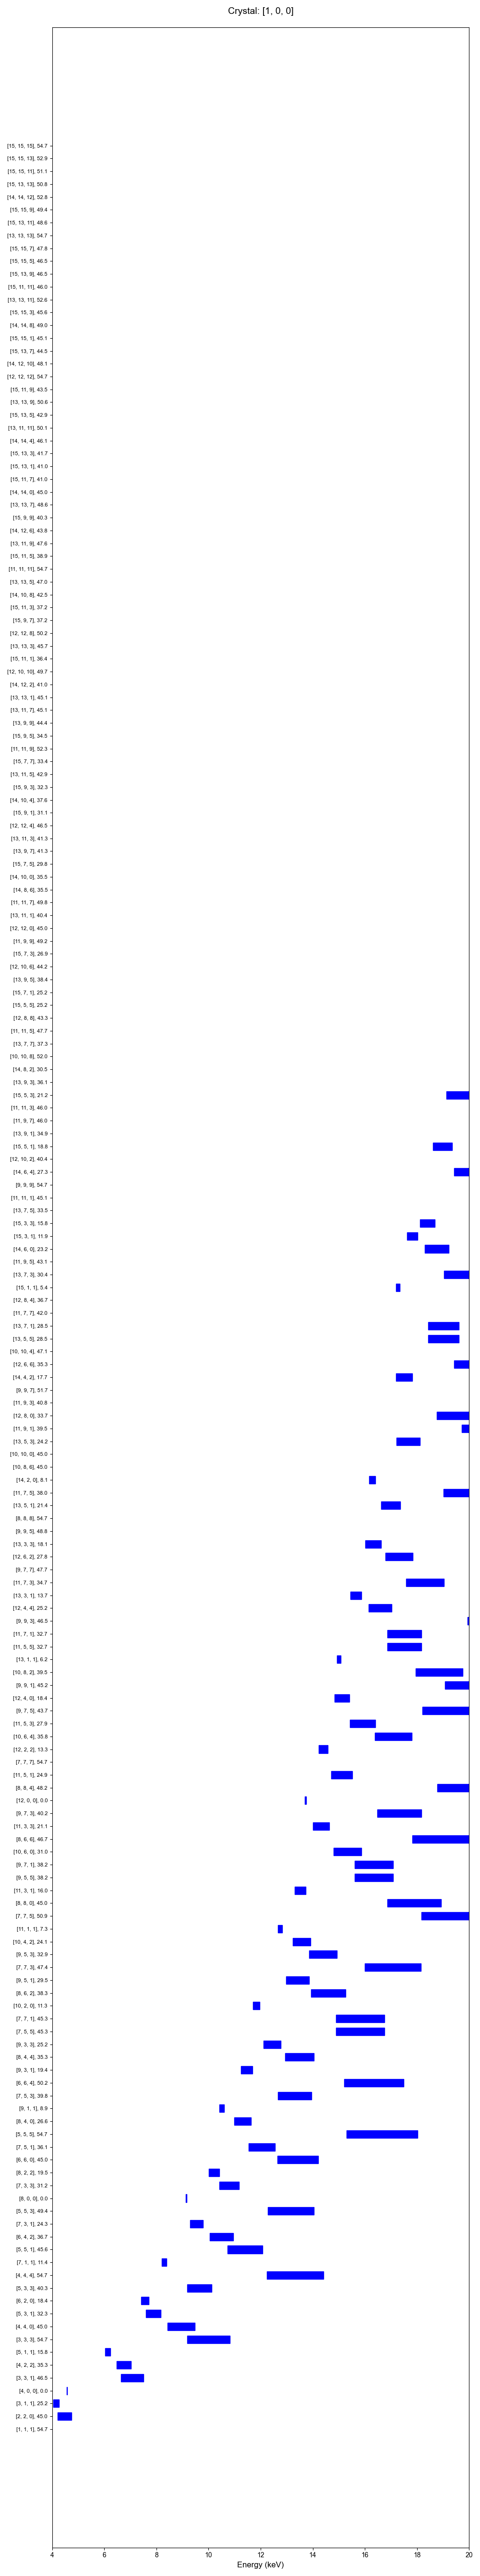

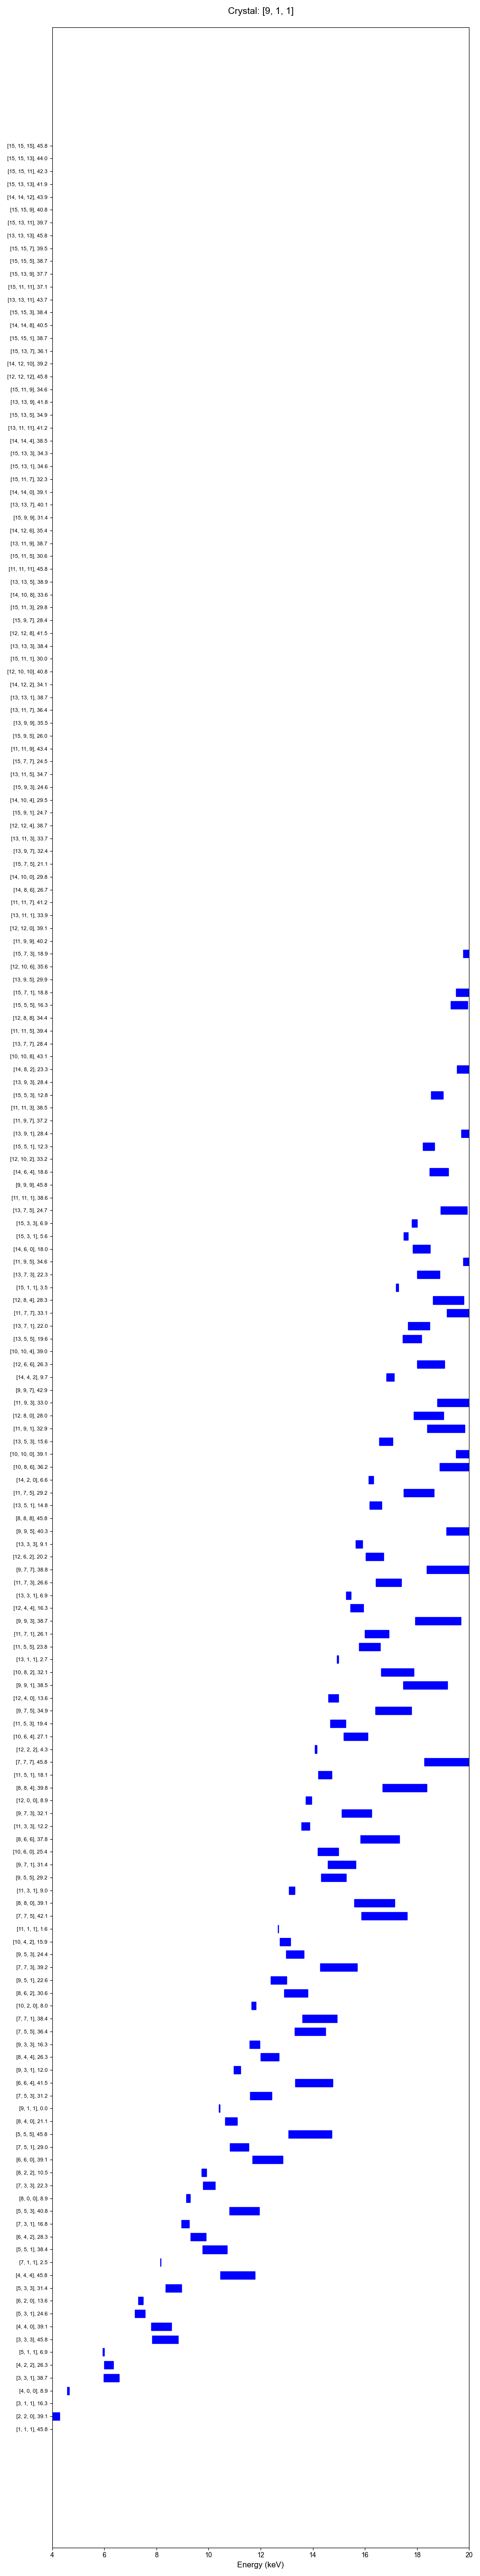

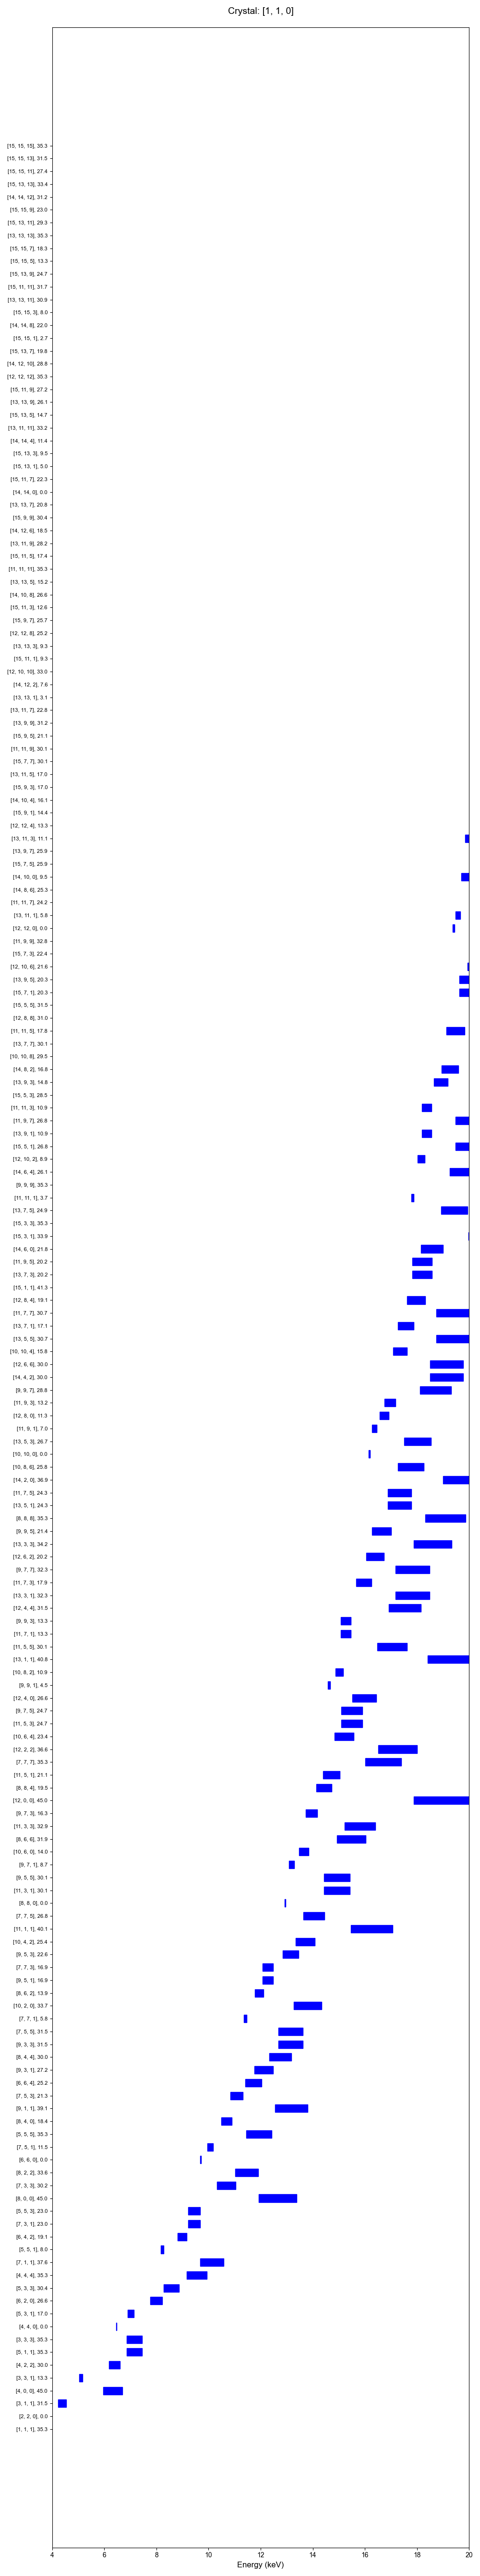

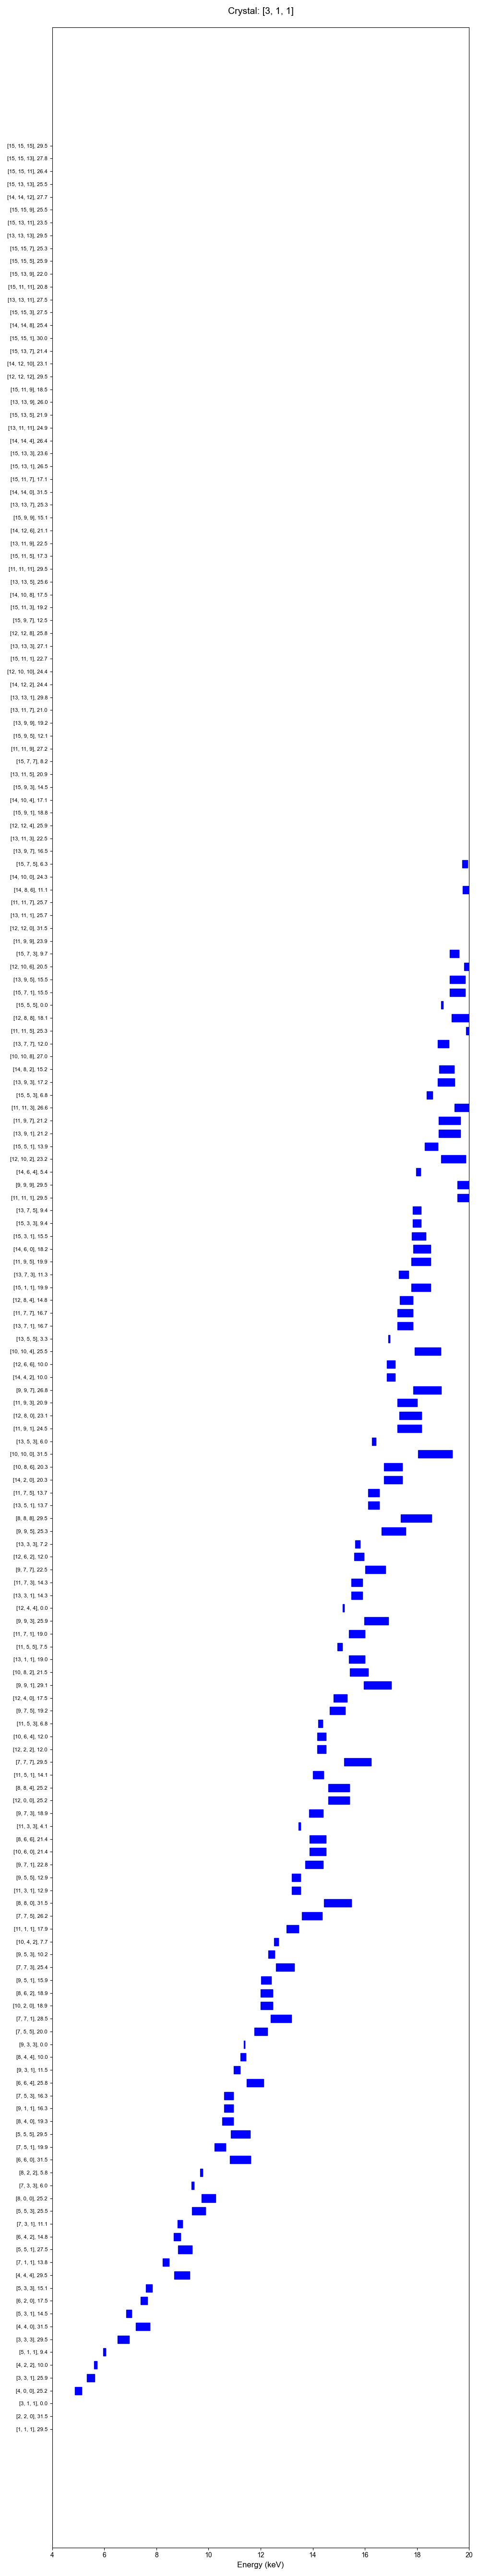

In [399]:
crystals = [[2,1,1],[7,7,3],[1,1,1],[1,0,0],[9,1,1],[1,1,0],[3,1,1]]
ordered_hkl_list = order_hkl_by_sum_of_squares(generate_hkl(15))
for crystal in crystals:
    hkl_df=hkl_dataframe_thetaM(hkl0=crystal, hkl_list = ordered_hkl_list, theta_M_range=np.arange(88, 96, 1), figure=True, pltEmin=4000, pltEmax=20000, fig_title=None)

In [400]:
# emission_lines = [5000, 6000]

# emission = pd.read_csv("EmissionLine.csv")

# crystals = [[2,1,1],[7,7,3],[1,1,1],[1,0,0],[9,1,1],[1,1,0],[3,1,1]]
# geometry_list = []

# for emis in emission_lines:
#     for crys in crystals:
#         crys_dic = {"Emission":emis,"Crystal": crys}
#         try:
#             geometry_dic = herfd_roland_circle(hkl0=crys, E_emission=emis, beta=30, angle2beam=90, view=[120,240,-30], reflected=True, focus=True, angle_list=False, threeD=False)
#             geometry = crys_dic | geometry_dic
#             geometry_list.append(geometry)
#         except Exception as e:
#             print(f"Error with E={emis}, hkl={crys}: {e}")

# df = pd.DataFrame(geometry_list)
# df.to_csv("herfd_geometry.csv", index=False)

In [401]:
# #hkl0 = [2,1,1] # lattice plane for SBCA

# crystals=[[7,7,3],[1,1,1],[1,0,0],[9,1,1],[1,1,0],[3,1,1],[2,1,1]]

# pks = [5483, 6208, 7243, 7112, 5723, 6977, 8358, 9244, 10367, 17038]

# for hkl0 in crystals:
#     print(f"-----------------------------{hkl0}-----------------------------------")
#     for E_emission in pks:
#         herfd_roland_circle(E_emission=E_emission, beta=30, angle2beam=90, view=[120,240,-30], reflected=True, focus=True, angle_list=True, threeD=False)
#         print("------------------------------------------------------------------------")

# 5. Energy velocity

In [402]:
def dE_dtheta(energy_val_eV, hkl=[4, 4, 4]):
    """
    Calculate derivative dE/dθ (eV per degree).
    Formula: dE/dθ = -E * cot(θ) * π/180
    """
    theta_deg = theta_bragg(energy_val_eV, hkl)
   
    theta_rad = np.radians(theta_deg)
  
    cot_theta = np.cos(theta_rad) / np.sin(theta_rad)

    return -energy_val_eV * cot_theta * (np.pi / 180), theta_deg


def energy_velocity_from_theta_speed(energy_val_eV, hkl=[4, 4, 4], theta_speed_deg_s=1.0):
    """
    Convert theta motor velocity (deg/s) → energy velocity (eV/s)
    """
    slope, theta = dE_dtheta(energy_val_eV, hkl)
    return slope * theta_speed_deg_s


def theta_speed_for_energy_velocity(energy_val_eV, hkl=[4, 4, 4], energy_velocity_eV_s=10):
    """
    Convert desired energy velocity (eV/s) → required theta motor speed (deg/s)
    """
    slope, theta = dE_dtheta(energy_val_eV, hkl)
    return energy_velocity_eV_s / slope


# ----------------- Example Use -----------------
if __name__ == "__main__":
    
    hkl0=[2,1,1] 
    hkl_phi0=[1,1,1]
    thetaB_range = np.arange(60,85,1)
    delAlpha=15
    deltTheB=10
    beta=0 

    theta_speed = 1  # deg/s

    energy_val_eV = 8000  # eV (example)
    hkl = find_hkl(hkl0=hkl0, hkl_list = ordered_hkl_list, thetaB_range = thetaB_range, energy_val=energy_val_eV, delEn=0, delEp=0, delAlpha=delAlpha, delThetaB=deltTheB)
    slope, theta_deg = dE_dtheta(energy_val_eV, hkl)
    energy_speed = energy_velocity_from_theta_speed(energy_val_eV, hkl, theta_speed)

    print(f"Energy = {energy_val_eV} eV")
    print(f"hkl = {hkl}")
    print(f"Bragg angle: {theta_deg:.4f} deg")
    print(f"dE/dtheta: {slope:.6f} eV/deg")
    print(f"Energy speed at theta speed {theta_speed} deg/s: {energy_speed:.2f} eV/s")

Energy = 8000 eV
hkl = [4, 4, 4]
Bragg angle: 81.3148 deg
dE/dtheta: -21.328897 eV/deg
Energy speed at theta speed 1 deg/s: -21.33 eV/s


In [403]:
energy_val_eV = 8100  # eV (example)
hkl = find_hkl(hkl0=hkl0, hkl_list = ordered_hkl_list, thetaB_range = thetaB_range, energy_val=energy_val_eV, delEn=0, delEp=0, delAlpha=delAlpha, delThetaB=deltTheB)
slope, theta_deg = dE_dtheta(energy_val_eV, hkl)
energy_speed = energy_velocity_from_theta_speed(energy_val_eV, hkl, theta_speed)

print(f"Energy = {energy_val_eV} eV")
print(f"hkl = {hkl}")
print(f"Bragg angle: {theta_deg:.4f} deg")
print(f"dE/dtheta: {slope:.6f} eV/deg")
print(f"Energy speed at theta speed {theta_speed} deg/s: {energy_speed:.2f} eV/s")

Energy = 8100 eV
hkl = [4, 4, 4]
Bragg angle: 77.5087 deg
dE/dtheta: -31.318837 eV/deg
Energy speed at theta speed 1 deg/s: -31.32 eV/s


In [404]:
hkl0 = [2, 1, 1]
thetaB_range = np.arange(60, 85, 1)
delAlpha = 30
deltTheB = 10

# Energy range request
energy_list_eV = np.arange(4000, 20000 + 1, 10)  # 4000 → 20000, step 10

# User-defined theta speeds to evaluate
theta_speed_list_deg_s = [1, 2, 5, 10]

results = []

for energy_val_eV in energy_list_eV:

    try:
        hkl = find_hkl(
            hkl0=hkl0,
            hkl_list=ordered_hkl_list,
            thetaB_range=thetaB_range,
            energy_val=energy_val_eV,
            delEn=0, delEp=0,
            delAlpha=delAlpha,
            delThetaB=deltTheB,
        )
    except Exception:
        # If no crystal satisfies this energy, record as "None" and skip
        results.append({"Energy_eV": energy_val_eV, "hkl": None})
        continue

    slope, theta_deg = dE_dtheta(energy_val_eV, hkl)

    row = {
        "Energy_eV": energy_val_eV,
        "hkl": str(hkl),
        "thetaB_deg": theta_deg,
        "dE_dtheta_eV_per_deg": slope,
    }

    # Add energy scan speed columns for each theta speed
    for speed in theta_speed_list_deg_s:
        row[f"{speed}_deg_per_s"] = energy_velocity_from_theta_speed(
            energy_val_eV, hkl, speed
        )

    results.append(row)

# Convert to DataFrame
df = pd.DataFrame(results)

# Save CSV
csv_name = "energy_velocity_4000_20000_step10.csv"
df.to_csv(csv_name, index=False)